## Import the necessary packages

In [277]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor , plot_importance
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
#import pycountry
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
warnings.filterwarnings('ignore')

# Import and analyze data

In [160]:
# import train data
df_train=pd.read_csv("train.csv")
df_train.tail(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
35364,35677,NaN,Zimbabwe,2020-05-09,35.0,4.0
35365,35678,NaN,Zimbabwe,2020-05-10,36.0,4.0
35366,35679,NaN,Zimbabwe,2020-05-11,36.0,4.0
35367,35680,NaN,Zimbabwe,2020-05-12,36.0,4.0
35368,35681,NaN,Zimbabwe,2020-05-13,37.0,4.0


## Data Cleaning

In [161]:
# identify the NAN values
df_train.isna().sum()

Id                    0
Province_State    20340
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [162]:
df_train['Province_State'].isna().sum()

20340

In [163]:
df_train['Province_State']=df_train['Province_State'].fillna('')
df_train['Province_State'].isna().sum()

0

In [164]:
#Concatinate the columns "Province_state" and "Country_region"
#df_train.sort_values(by=['Date'],inplace=True)
df_train['Country_Region']=df_train['Country_Region']+'_'+df_train['Province_State']

In [165]:
df_train

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,,Afghanistan_,2020-01-22,0.0,0.0
1,2,,Afghanistan_,2020-01-23,0.0,0.0
2,3,,Afghanistan_,2020-01-24,0.0,0.0
3,4,,Afghanistan_,2020-01-25,0.0,0.0
4,5,,Afghanistan_,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
35364,35677,,Zimbabwe_,2020-05-09,35.0,4.0
35365,35678,,Zimbabwe_,2020-05-10,36.0,4.0
35366,35679,,Zimbabwe_,2020-05-11,36.0,4.0
35367,35680,,Zimbabwe_,2020-05-12,36.0,4.0


In [166]:
# import test data
df_test=pd.read_csv("test.csv")
df_test.sample(5)

,ForecastId,Province_State,Country_Region,Date
891,892,NaN,Bangladesh,2020-05-03
3125,3126,Jilin,China,2020-05-01
6383,6384,NaN,Japan,2020-04-21
8144,8145,NaN,Niger,2020-04-19
12197,12198,Utah,US,2020-04-30


In [167]:
df_test.isna().sum()

ForecastId           0
Province_State    7740
Country_Region       0
Date                 0
dtype: int64

In [168]:
df_test['Province_State']=df_test['Province_State'].fillna('')
df_test['Province_State'].isna().sum()

0

In [169]:
df_test

,ForecastId,Province_State,Country_Region,Date
0,1,,Afghanistan,2020-04-02
1,2,,Afghanistan,2020-04-03
2,3,,Afghanistan,2020-04-04
3,4,,Afghanistan,2020-04-05
4,5,,Afghanistan,2020-04-06
...,...,...,...,...
13454,13455,,Zimbabwe,2020-05-10
13455,13456,,Zimbabwe,2020-05-11
13456,13457,,Zimbabwe,2020-05-12
13457,13458,,Zimbabwe,2020-05-13


In [170]:
df_test['Country_Region']=df_test['Country_Region']+'_'+df_test['Province_State']

In [171]:
df_test.sample(8)

,ForecastId,Province_State,Country_Region,Date
8672,8673,,Portugal_,2020-05-01
6724,6725,,Laos_,2020-04-18
10546,10547,District of Columbia,US_District of Columbia,2020-04-13
9485,9486,,South Africa_,2020-04-27
9349,9350,,Slovakia_,2020-04-20
10481,10482,Connecticut,US_Connecticut,2020-05-04
7263,7264,,Maldives_,2020-05-11
1133,1134,,Bhutan_,2020-04-17


## Data preprocessing

### Feature generation


In [172]:
# Create function new date features such as year, mounth, day from Date feature
def create_features(df,label=None):
    df = df.copy()
    df['Date'] = df.index
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [173]:
# generate date features  from train dataset
train = df_train.set_index(['Date'])
train.index = pd.to_datetime(train.index)
train_features=pd.DataFrame(create_features(train))
train_features

,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
Date,,,,,,
2020-01-22,2,1,1,22,22,4
2020-01-23,3,1,1,23,23,4
2020-01-24,4,1,1,24,24,4
2020-01-25,5,1,1,25,25,4
2020-01-26,6,1,1,26,26,4
...,...,...,...,...,...,...
2020-05-09,5,2,5,130,9,19
2020-05-10,6,2,5,131,10,19
2020-05-11,0,2,5,132,11,20


In [174]:
# Concatinate the new features with the train dataset
df_train_final = pd.concat([train,train_features], axis=1)
df_train_final.reset_index(drop=True ,inplace =True )
df_train_final

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,1,,Afghanistan_,0.0,0.0,2,1,1,22,22,4
1,2,,Afghanistan_,0.0,0.0,3,1,1,23,23,4
2,3,,Afghanistan_,0.0,0.0,4,1,1,24,24,4
3,4,,Afghanistan_,0.0,0.0,5,1,1,25,25,4
4,5,,Afghanistan_,0.0,0.0,6,1,1,26,26,4
...,...,...,...,...,...,...,...,...,...,...,...
35364,35677,,Zimbabwe_,35.0,4.0,5,2,5,130,9,19
35365,35678,,Zimbabwe_,36.0,4.0,6,2,5,131,10,19
35366,35679,,Zimbabwe_,36.0,4.0,0,2,5,132,11,20
35367,35680,,Zimbabwe_,36.0,4.0,1,2,5,133,12,20


## Qualitative features encoder

In [175]:
# encode the qualitative feature "Country_Region"
le = LabelEncoder()
df_train_final['Country_Region'] = le.fit_transform(df_train_final['Country_Region'])

In [176]:
df_train_final.sample(8)

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
23299,23506,,206,0.0,0.0,2,1,2,43,12,7
17124,17276,,151,16.0,0.0,0,1,3,83,23,13
32839,33130,Wyoming,290,109.0,0.0,1,1,3,91,31,14
19146,19316,,169,0.0,0.0,2,1,3,71,11,11
22440,22639,,198,671.0,16.0,5,1,3,88,28,13
12908,13023,French Polynesia,115,0.0,0.0,0,1,2,48,17,8
27448,27691,Colorado,242,16635.0,842.0,6,2,5,124,3,18
10120,10210,,89,48.0,2.0,2,1,3,85,25,13


In [177]:
df_train_final.drop(columns='Province_State' , inplace=True)
df_train_final

,Id,Country_Region,ConfirmedCases,Fatalities,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,1,0,0.0,0.0,2,1,1,22,22,4
1,2,0,0.0,0.0,3,1,1,23,23,4
2,3,0,0.0,0.0,4,1,1,24,24,4
3,4,0,0.0,0.0,5,1,1,25,25,4
4,5,0,0.0,0.0,6,1,1,26,26,4
...,...,...,...,...,...,...,...,...,...,...
35364,35677,312,35.0,4.0,5,2,5,130,9,19
35365,35678,312,36.0,4.0,6,2,5,131,10,19
35366,35679,312,36.0,4.0,0,2,5,132,11,20
35367,35680,312,36.0,4.0,1,2,5,133,12,20


In [178]:
# generate date features from test dataset
test = df_test.set_index(['Date'])
test.index = pd.to_datetime(test.index)
test_features=pd.DataFrame(create_features(test))
test_features

,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
Date,,,,,,
2020-04-02,3,2,4,93,2,14
2020-04-03,4,2,4,94,3,14
2020-04-04,5,2,4,95,4,14
2020-04-05,6,2,4,96,5,14
2020-04-06,0,2,4,97,6,15
...,...,...,...,...,...,...
2020-05-10,6,2,5,131,10,19
2020-05-11,0,2,5,132,11,20
2020-05-12,1,2,5,133,12,20


In [179]:
# Concatinate the new features with the test dataset
df_test_final = pd.concat([test,test_features], axis=1)
df_test_final.reset_index(drop=True ,inplace =True )
df_test_final

,ForecastId,Province_State,Country_Region,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,1,,Afghanistan_,3,2,4,93,2,14
1,2,,Afghanistan_,4,2,4,94,3,14
2,3,,Afghanistan_,5,2,4,95,4,14
3,4,,Afghanistan_,6,2,4,96,5,14
4,5,,Afghanistan_,0,2,4,97,6,15
...,...,...,...,...,...,...,...,...,...
13454,13455,,Zimbabwe_,6,2,5,131,10,19
13455,13456,,Zimbabwe_,0,2,5,132,11,20
13456,13457,,Zimbabwe_,1,2,5,133,12,20
13457,13458,,Zimbabwe_,2,2,5,134,13,20


In [180]:
# encode the qualitative feature "Country_Region" for test dataset
le = LabelEncoder()
df_test_final['Country_Region'] = le.fit_transform(df_test_final['Country_Region'])

In [181]:
df_test_final.sample(8)

,ForecastId,Province_State,Country_Region,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
6546,6547,,152,6,2,4,103,12,15
13185,13186,,306,2,2,4,120,29,18
1331,1332,,30,2,2,5,134,13,20
11294,11295,Mississippi,262,3,2,4,121,30,18
2819,2820,Henan,65,6,2,4,117,26,17
10023,10024,,233,0,2,4,97,6,15
10712,10713,Hawaii,249,1,2,4,98,7,15
1731,1732,British Columbia,40,0,2,4,104,13,16


In [182]:
df_test_final.drop(columns='Province_State' , inplace=True)
df_test_final

,ForecastId,Country_Region,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,1,0,3,2,4,93,2,14
1,2,0,4,2,4,94,3,14
2,3,0,5,2,4,95,4,14
3,4,0,6,2,4,96,5,14
4,5,0,0,2,4,97,6,15
...,...,...,...,...,...,...,...,...
13454,13455,312,6,2,5,131,10,19
13455,13456,312,0,2,5,132,11,20
13456,13457,312,1,2,5,133,12,20
13457,13458,312,2,2,5,134,13,20


In [183]:
# drop forcast id_feature
df_test_final = df_test_final.drop(['ForecastId'],axis=1)

#### Visualize correlation

In [184]:
df_train_final.corr()

,Id,Country_Region,ConfirmedCases,Fatalities,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
Id,1.000000,9.999465e-01,0.067214,0.048608,-7.240902e-05,2.663144e-03,3.061237e-03,0.003167,-3.558966e-04,3.160862e-03
Country_Region,0.999946,1.000000e+00,0.064351,0.044983,-7.138652e-20,-9.158854e-20,5.855510e-19,0.000000,-1.242844e-19,-4.870011e-19
ConfirmedCases,0.067214,6.435132e-02,1.000000,0.892338,-5.589358e-03,2.098612e-01,2.054821e-01,0.212172,-2.776997e-02,2.118229e-01
Fatalities,0.048608,4.498308e-02,0.892338,1.000000,-3.748819e-03,1.518791e-01,1.473950e-01,0.152502,-1.894126e-02,1.522353e-01
dayofweek,-0.000072,-7.138652e-20,-0.005589,-0.003749,1.000000e+00,-5.664436e-03,-1.129996e-02,-0.022865,-4.012787e-02,-8.370220e-02
quarter,0.002663,-9.158854e-20,0.209861,0.151879,-5.664436e-03,1.000000e+00,8.421990e-01,0.840974,-2.237671e-01,8.385868e-01
month,0.003061,5.855510e-19,0.205482,0.147395,-1.129996e-02,8.421990e-01,1.000000e+00,0.966684,-3.626749e-01,9.642323e-01
dayofyear,0.003167,0.000000e+00,0.212172,0.152502,-2.286548e-02,8.409737e-01,9.666843e-01,1.000000,-1.123858e-01,9.981442e-01
dayofmonth,-0.000356,-1.242844e-19,-0.027770,-0.018941,-4.012787e-02,-2.237671e-01,-3.626749e-01,-0.112386,1.000000e+00,-1.095765e-01
weekofyear,0.003161,-4.870011e-19,0.211823,0.152235,-8.370220e-02,8.385868e-01,9.642323e-01,0.998144,-1.095765e-01,1.000000e+00


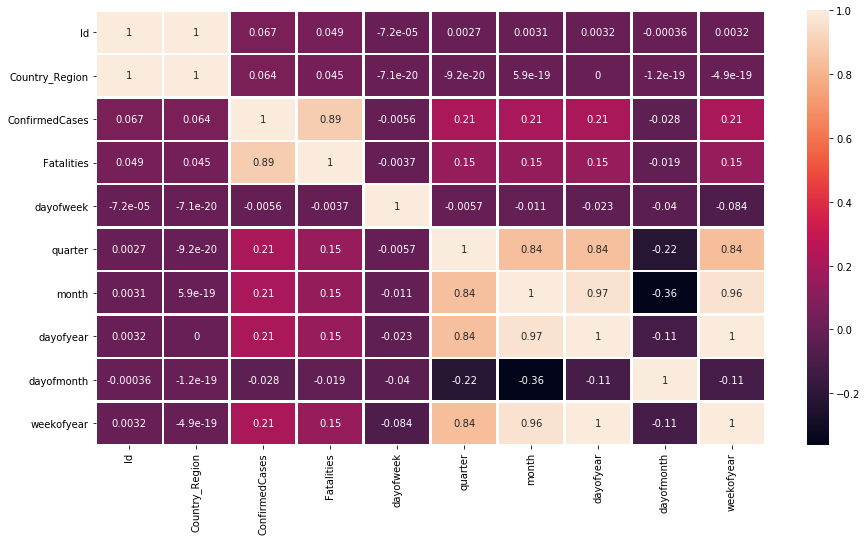

In [185]:
plt.figure(figsize=(15,8))
sns.heatmap(df_train_final.corr(),annot=True , linewidth=1.5 )

#### After we visualize the correlation between the features, we can note that "mounth" , "weekofyear", "dayofyear" and "quarter" are high correlated. We can explain that by the generation of this feature from the original feature "date".Also, the two target features "ConfirmedCases" and "Fatalities" are correlated

In [186]:
# transform the two target features into integer type
df_train_final['ConfirmedCases'] = df_train_final['ConfirmedCases'].apply(int)
df_train_final['Fatalities'] = df_train_final['Fatalities'].apply(int)

#### prepare the final dataframes for the modeling steps

In [187]:
df_train_final.columns

Index(['Id', 'Country_Region', 'ConfirmedCases', 'Fatalities', 'dayofweek',
       'quarter', 'month', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [188]:
y_conf=df_train_final['ConfirmedCases']
y_conf.sample(6)
y_fat=df_train_final['Fatalities']

In [189]:
# drop 'id' and 'Fatalities' features for fatalities modeling
df_train_final_fat = df_train_final.drop(['Id','Fatalities'],axis=1)
df_train_final_fat.columns

Index(['Country_Region', 'ConfirmedCases', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [190]:
# drop 'id', 'ConfirmedCases' and 'Fatalities' for confirmed cases modeling
df_train_final_ConCases = df_train_final.drop(['Id','ConfirmedCases','Fatalities'],axis=1)
df_train_final_ConCases.columns

Index(['Country_Region', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [191]:
df_train_final_fat

,Country_Region,ConfirmedCases,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,0,2,1,1,22,22,4
1,0,0,3,1,1,23,23,4
2,0,0,4,1,1,24,24,4
3,0,0,5,1,1,25,25,4
4,0,0,6,1,1,26,26,4
...,...,...,...,...,...,...,...,...
35364,312,35,5,2,5,130,9,19
35365,312,36,6,2,5,131,10,19
35366,312,36,0,2,5,132,11,20
35367,312,36,1,2,5,133,12,20


## Modeling

## XGBRegressor

In [192]:
#Modeling the confirmedcases
# split train dataset inorder to choose the best model

X_train,X_test,y_train,y_test = train_test_split(df_train_final_ConCases,y_conf,test_size=0.2,random_state=42)

In [193]:
# implement the XGBRegressor and fit the model
rf = XGBRegressor(n_estimators = 2400 , random_state = 0 , max_depth = 26)
rf.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=26,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [194]:
# predict the test value 
pred_conf = rf.predict(X_test)
predictions = [round(value) for value in pred_conf]
#predictions

#### evaluate the XGRegressor

In [195]:
rf.score(X_train,y_train)

0.999999999999974

In [196]:
rf.score(X_test,y_test)

0.9979586767097989

In [197]:
mse = mean_squared_error(y_test,predictions)
print('MSE: %f' % mse)

MSE: 752985.258977


In [198]:
r=np.sqrt(mean_squared_error(y_test,predictions))
r

867.7472321918024

In [199]:
mae = mean_absolute_error(y_test,predictions)
print('MAE: %f' % mae)

MAE: 156.801809


In [200]:
from math import sqrt
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 867.747232


In [201]:
R2=r2_score(y_test,predictions)
print('R2: %f' % R2)

R2: 0.997959


#### after evaluating the XGBRegressor, we find that it is the perfect model to train and predict both the confirmedcases and fatalities with R^2=0.997 and RMSE=867.74 and the train and test scores give a high value which means that the model isn't overfitted and we can see that by observing the predicted values.

In [256]:
#Compare the results between pred and confirmed cases
dfpred = pd.DataFrame(data=predictions, columns=[ "pred"] , index=y_test.index )
dfpred1=pd.concat([dfpred,y_test],axis=1)
dfpred1.sample(30)

,pred,ConfirmedCases
25756,30009.0,30060
17936,627.0,632
27625,15.0,7
7555,1037.0,1037
25165,153407.0,158273
24824,16.0,12
19469,0.0,0
25187,214693.0,216582
1240,29.0,29
10581,314.0,269


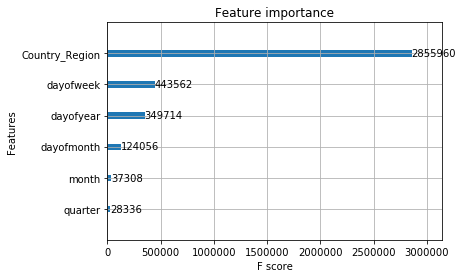

In [203]:
#Get the feature importance in the XGBRegressor model
plot_importance(rf);

In [249]:
### the same work to train and predict fatalities
X_train2,X_test2,y_train2,y_test2 = train_test_split(df_train_final_fat,y_fat,test_size=0.2,random_state=42)

In [205]:
rf2 = XGBRegressor(n_estimators = 2000 , random_state = 0 , max_depth = 20)
rf2.fit(X_train2,y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [206]:
pred_fat = rf2.predict(X_test2)
predictions_fat = [round(value) for value in pred_fat]
#predictions_fat

In [207]:
rf2.score(X_test2,y_test2)

0.9638946004745621

In [208]:
r=np.sqrt(mean_squared_error(y_test2,predictions_fat))
r

368.4261560817268

In [209]:
mae2 = mean_absolute_error(y_test2,predictions_fat)
print('MAE: %f' % mae2)

MAE: 27.280040


In [210]:
mse2 = mean_squared_error(y_test2,predictions_fat)
print('MSE: %f' % mse2)

MSE: 135737.832485


In [211]:
rmse2 = sqrt(mse2)
print('RMSE: %f' % rmse2)

RMSE: 368.426156


In [212]:
R2_fat=r2_score(y_test2,predictions_fat)
print('R2: %f' % R2_fat)

R2: 0.963893


In [213]:
dfpred_fat = pd.DataFrame(data=predictions_fat, columns=[ "pred"] , index=y_test2.index )
dfpred_fat1=pd.concat([dfpred_fat,y_test2],axis=1)
dfpred_fat1.sample(30)

,pred,Fatalities
10812,111.0,99
6876,2.0,2
26085,10.0,10
6896,-0.0,0
2918,1.0,1
18585,0.0,0
23759,0.0,0
10577,4.0,4
585,0.0,0
10250,3.0,3


In [214]:

accuracy = accuracy_score(y_test2,predictions_fat)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.55%


#### after evaluating the XGBRegressor, we find that it is the perfect model to train and predict both the confirmedcases and fatalities with R^2 close to 1 and a low value of RMSE and the train and test scores give a high value which means that the model isn't overfitted and we can see that by observing the predicted values.

In [215]:
# Apply the model for the confirmedcases
xgb = XGBRegressor(n_estimators = 2400 , random_state = 0 , max_depth = 26)
xgb.fit(df_train_final_ConCases,y_conf)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=26,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [216]:
df_train_final_fat

,Country_Region,ConfirmedCases,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,0,2,1,1,22,22,4
1,0,0,3,1,1,23,23,4
2,0,0,4,1,1,24,24,4
3,0,0,5,1,1,25,25,4
4,0,0,6,1,1,26,26,4
...,...,...,...,...,...,...,...,...
35364,312,35,5,2,5,130,9,19
35365,312,36,6,2,5,131,10,19
35366,312,36,0,2,5,132,11,20
35367,312,36,1,2,5,133,12,20


In [217]:
df_test_final

,Country_Region,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,3,2,4,93,2,14
1,0,4,2,4,94,3,14
2,0,5,2,4,95,4,14
3,0,6,2,4,96,5,14
4,0,0,2,4,97,6,15
...,...,...,...,...,...,...,...
13454,312,6,2,5,131,10,19
13455,312,0,2,5,132,11,20
13456,312,1,2,5,133,12,20
13457,312,2,2,5,134,13,20


In [218]:
pred_conf = xgb.predict(df_test_final)
predictions_conf = [round(value) for value in pred_conf]
#predictions_conf

In [219]:
predictions_conf  = np.around(predictions_conf ,decimals = 0)
predictions_conf 

array([273., 281., 299., ...,  36.,  37.,  37.], dtype=float32)

In [220]:
#Concatinate the preticted ConfirmedCases into dataframe in order to predict fatalities
conf_test=pd.DataFrame(predictions_conf,index=df_test_final.index,columns=["ConfirmedCases"])
df_test_final=pd.concat([df_test_final,conf_test],axis=1)

In [221]:
df_test_final.loc[10135]

Country_Region     235.0
dayofweek            5.0
quarter              2.0
month                5.0
dayofyear          123.0
dayofmonth           2.0
weekofyear          18.0
ConfirmedCases    1009.0
Name: 10135, dtype: float64

In [222]:
xgb2 = XGBRegressor(n_estimators = 2400 , random_state = 0 , max_depth = 26)
xgb2.fit(df_train_final_fat,y_fat)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=26,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [223]:
df_test_final

,Country_Region,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,ConfirmedCases
0,0,3,2,4,93,2,14,273.0
1,0,4,2,4,94,3,14,281.0
2,0,5,2,4,95,4,14,299.0
3,0,6,2,4,96,5,14,349.0
4,0,0,2,4,97,6,15,367.0
...,...,...,...,...,...,...,...,...
13454,312,6,2,5,131,10,19,36.0
13455,312,0,2,5,132,11,20,36.0
13456,312,1,2,5,133,12,20,36.0
13457,312,2,2,5,134,13,20,37.0


In [224]:
df_test_final=df_test_final[['Country_Region', 'ConfirmedCases', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'dayofmonth', 'weekofyear']]

In [225]:
df_test_final

,Country_Region,ConfirmedCases,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,273.0,3,2,4,93,2,14
1,0,281.0,4,2,4,94,3,14
2,0,299.0,5,2,4,95,4,14
3,0,349.0,6,2,4,96,5,14
4,0,367.0,0,2,4,97,6,15
...,...,...,...,...,...,...,...,...
13454,312,36.0,6,2,5,131,10,19
13455,312,36.0,0,2,5,132,11,20
13456,312,36.0,1,2,5,133,12,20
13457,312,37.0,2,2,5,134,13,20


In [226]:
pred_fat = xgb2.predict(df_test_final)
predictions_fat = [round(value) for value in pred_fat]
#predictions_fat

In [227]:
predictions_fat  = np.around(predictions_fat ,decimals = 0)
predictions_fat 

array([6., 6., 7., ..., 4., 4., 4.], dtype=float32)

#### Submission file

In [228]:
df_sub=pd.read_csv("submission.csv")
df_sub.tail(5)

,ForecastId,ConfirmedCases,Fatalities
13454,13455,36.0,4.0
13455,13456,36.0,4.0
13456,13457,36.0,4.0
13457,13458,37.0,4.0
13458,13459,37.0,4.0


In [229]:
df_sub['ConfirmedCases']=predictions_conf
df_sub['Fatalities']=predictions_fat

In [230]:
df_sub

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0
...,...,...,...
13454,13455,36.0,4.0
13455,13456,36.0,4.0
13456,13457,36.0,4.0
13457,13458,37.0,4.0


In [231]:
## apply method to eliminate overfitting
df_sub.to_csv("submission.csv" , index = False)

## Deep Neaural Network

In [238]:
# Build the Neural network for regression problem using 5 hidden layer and relu as activation function
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_44 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_45 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_46 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_47 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 257       
Total params: 231,681
Trainable params: 231,681
Non-trainable params: 0
________________________________________________

In [239]:
#use the method Modelcheckpoint to calculate the best weights parameters in order to avoid overfitt
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 22636 samples, validate on 5659 samples
Epoch 1/500
22636/22636 [==============================] - 3s 134us/step - loss: 3438.8663 - mean_absolute_error: 3438.8652 - val_loss: 3244.2992 - val_mean_absolute_error: 3244.2993

Epoch 00001: val_loss improved from inf to 3244.29919, saving model to Weights-001--3244.29919.hdf5
Epoch 2/500
22636/22636 [==============================] - 3s 127us/step - loss: 3431.4690 - mean_absolute_error: 3431.4692 - val_loss: 3253.5791 - val_mean_absolute_error: 3253.5784

Epoch 00002: val_loss did not improve from 3244.29919
Epoch 3/500
22636/22636 [==============================] - 3s 131us/step - loss: 3421.5450 - mean_absolute_error: 3421.5447 - val_loss: 3228.3347 - val_mean_absolute_error: 3228.3342

Epoch 00003: val_loss improved from 3244.29919 to 3228.33468, saving model to Weights-003--3228.33468.hdf5
Epoch 4/500
22636/22636 [==============================] - 3s 138us/step - loss: 3420.2046 - mean_absolute_error: 3420.2029 - val_loss: 32

In [240]:
# Load wights file of the best model 
# choose the best checkpoint 
wights_file = 'Weights-447--2962.83062.hdf5'
NN_model.load_weights(wights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [241]:
predictionsnn = NN_model.predict(X_test)
predictionsnn

array([[1.6328319e+02],
       [3.7195591e+01],
       [5.9819699e-04],
       ...,
       [4.0910752e+03],
       [5.9819699e-04],
       [5.9819699e-04]], dtype=float32)

In [243]:
# Comparing prediction with the real values
dfpred = pd.DataFrame(data=predictionsnn, columns=[ "pred"] , index=y_test.index )
dfpred1=pd.concat([dfpred,y_test],axis=1)
dfpred1.sample(30)

,pred,ConfirmedCases
12302,244.241135,1666
538,151.056244,19
17102,0.000598,0
9527,142.048309,76
13177,53.686054,128
20035,0.000598,0
25165,352.248230,158273
18900,0.000598,22
21769,790.789551,5550
29920,4105.939453,433


In [244]:
# Use the early stopping method in order to avoid overfitting problem
early_stopping=EarlyStopping(patience=3)
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=[early_stopping])

Train on 22636 samples, validate on 5659 samples
Epoch 1/500
22636/22636 [==============================] - 3s 120us/step - loss: 3223.9460 - mean_absolute_error: 3223.9438 - val_loss: 3083.2320 - val_mean_absolute_error: 3083.2317
Epoch 2/500
22636/22636 [==============================] - 3s 113us/step - loss: 3212.0942 - mean_absolute_error: 3212.0940 - val_loss: 3139.0112 - val_mean_absolute_error: 3139.0117
Epoch 3/500
22636/22636 [==============================] - 3s 119us/step - loss: 3256.9002 - mean_absolute_error: 3256.8972 - val_loss: 3096.1963 - val_mean_absolute_error: 3096.1960
Epoch 4/500
22636/22636 [==============================] - 3s 120us/step - loss: 3240.6365 - mean_absolute_error: 3240.6370 - val_loss: 3053.2201 - val_mean_absolute_error: 3053.2214
Epoch 5/500
22636/22636 [==============================] - 3s 130us/step - loss: 3251.7197 - mean_absolute_error: 3251.7195 - val_loss: 3091.2897 - val_mean_absolute_error: 3091.2908
Epoch 6/500
22636/22636 [===========

In [245]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [246]:
predictionsnn2 = NN_model.predict(X_test)
predictionsnn2
dfpred = pd.DataFrame(data=predictionsnn2, columns=[ "pred"] , index=y_test.index )
dfpred2=pd.concat([dfpred,y_test],axis=1)
dfpred2.sample(30)

,pred,ConfirmedCases
6315,577.028748,593
33532,100.267029,3
14948,0.000119,0
14646,29.822781,1314
16623,0.000119,0
30772,0.000119,0
29572,2354.584229,1336
33785,279.135376,547
20882,96.982185,14
35118,28.256233,6


In [250]:
# prepare the model for prediction the fatalities values. The parameters are the same as the previous one.
NN_model_fat = Sequential()

# The Input Layer :
NN_model_fat.add(Dense(64, kernel_initializer='normal',input_dim = X_train2.shape[1], activation='relu'))

# The Hidden Layers :
NN_model_fat.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model_fat.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model_fat.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model_fat.add(Dense(128, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model_fat.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model_fat.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model_fat.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_62 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_63 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 129       
Total params: 58,561
Trainable params: 58,561
Non-trainable params: 0
_________________________________________________

In [252]:
early_stopping=EarlyStopping(patience=3)
NN_model_fat.fit(X_train2, y_train2, epochs=500, batch_size=32, validation_split = 0.2, callbacks=[early_stopping])
NN_model_fat.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Train on 22636 samples, validate on 5659 samples
Epoch 1/500
22636/22636 [==============================] - 2s 77us/step - loss: 121.3960 - mean_absolute_error: 121.3960 - val_loss: 110.2741 - val_mean_absolute_error: 110.2741
Epoch 2/500
22636/22636 [==============================] - 2s 67us/step - loss: 114.5180 - mean_absolute_error: 114.5180 - val_loss: 104.8340 - val_mean_absolute_error: 104.8339
Epoch 3/500
22636/22636 [==============================] - 2s 69us/step - loss: 113.5401 - mean_absolute_error: 113.5401 - val_loss: 118.8076 - val_mean_absolute_error: 118.8076
Epoch 4/500
22636/22636 [==============================] - 2s 74us/step - loss: 108.8357 - mean_absolute_error: 108.8357 - val_loss: 105.3159 - val_mean_absolute_error: 105.3159
Epoch 5/500
22636/22636 [==============================] - 2s 70us/step - loss: 110.5420 - mean_absolute_error: 110.5419 - val_loss: 115.6275 - val_mean_absolute_error: 115.6276


In [260]:
predictionsnnfat = NN_model_fat.predict(X_test2)
predictionsnnfat
predictions = [np.round(value) for value in predictionsnnfat]
dfpredfat = pd.DataFrame(data=predictions, columns=[ "pred"] , index=y_test2.index )
dfpredfat=pd.concat([dfpred,y_test2],axis=1)

In [276]:
# use method to enhance the performance of the XGBRegressor

In [261]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=df_train_final_ConCases.values,label=y_conf.values)

In [262]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 26, 'alpha': 10 , ' random_state ':0 , 'n_estimators ':2400}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=900,early_stopping_rounds=2,metrics="mae", as_pandas=True, seed=123)

[14:44:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: {  random_state , n_estimators  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:44:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: {  random_state , n_estimators  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:44:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: {  random_state , n_estimators  } might not be used.

  This may not be 

In [263]:
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,3437.353109,57.250946,3437.990153,112.571110
1,3382.717041,226.847615,3380.969157,124.840019
2,3153.344157,272.224969,3179.180746,258.232814


#### Apply another methods in order to predict confirmedcases and fatalities
#### Ridge

In [286]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [287]:
df_train_r=pd.read_csv("train.csv")
df_train_r.tail(5)
df_train1 = df_train_r.fillna('NA').groupby(['Country_Region','Date']).sum()
df_train1
df_train1.reset_index(inplace=True)
df_train1

,Country_Region,Date,Id,ConfirmedCases,Fatalities
0,Afghanistan,2020-01-22,1,0.0,0.0
1,Afghanistan,2020-01-23,2,0.0,0.0
2,Afghanistan,2020-01-24,3,0.0,0.0
3,Afghanistan,2020-01-25,4,0.0,0.0
4,Afghanistan,2020-01-26,5,0.0,0.0
...,...,...,...,...,...
20787,Zimbabwe,2020-05-09,35677,35.0,4.0
20788,Zimbabwe,2020-05-10,35678,36.0,4.0
20789,Zimbabwe,2020-05-11,35679,36.0,4.0
20790,Zimbabwe,2020-05-12,35680,36.0,4.0


In [288]:
df_test

,ForecastId,Province_State,Country_Region,Date
0,1,,Afghanistan_,2020-04-02
1,2,,Afghanistan_,2020-04-03
2,3,,Afghanistan_,2020-04-04
3,4,,Afghanistan_,2020-04-05
4,5,,Afghanistan_,2020-04-06
...,...,...,...,...
13454,13455,,Zimbabwe_,2020-05-10
13455,13456,,Zimbabwe_,2020-05-11
13456,13457,,Zimbabwe_,2020-05-12
13457,13458,,Zimbabwe_,2020-05-13


In [289]:
def getColumnInfo(df):
    #n_province =  df['Province_State'].nunique()
    n_country  =  df['Country_Region'].nunique()
    n_days     =  df['Date'].nunique()
    start_date =  df['Date'].unique()[0]
    end_date   =  df['Date'].unique()[-1]
    return  n_country, n_days, start_date, end_date

n_count_train, n_train_days, start_date_train, end_date_train = getColumnInfo(df_train1)
n_count_test,  n_test_days,  start_date_test,  end_date_test  = getColumnInfo(df_test)


df_test1 = df_test.loc[df_test.Date > '2020-05-10']
overlap_days = n_test_days - df_test1.Date.nunique()


In [290]:
    df_country_train = df_train1[df_train1['Country_Region']=='US' ]
    df_country_train

,Country_Region,Date,Id,ConfirmedCases,Fatalities
19323,US,2020-01-22,1622160,0.0,0.0
19324,US,2020-01-23,1622214,0.0,0.0
19325,US,2020-01-24,1622268,0.0,0.0
19326,US,2020-01-25,1622322,0.0,0.0
19327,US,2020-01-26,1622376,0.0,0.0
...,...,...,...,...,...
19431,US,2020-05-09,1627992,1309382.0,78790.0
19432,US,2020-05-10,1628046,1329092.0,79521.0
19433,US,2020-05-11,1628100,1347710.0,80677.0
19434,US,2020-05-12,1628154,1369403.0,82371.0


74


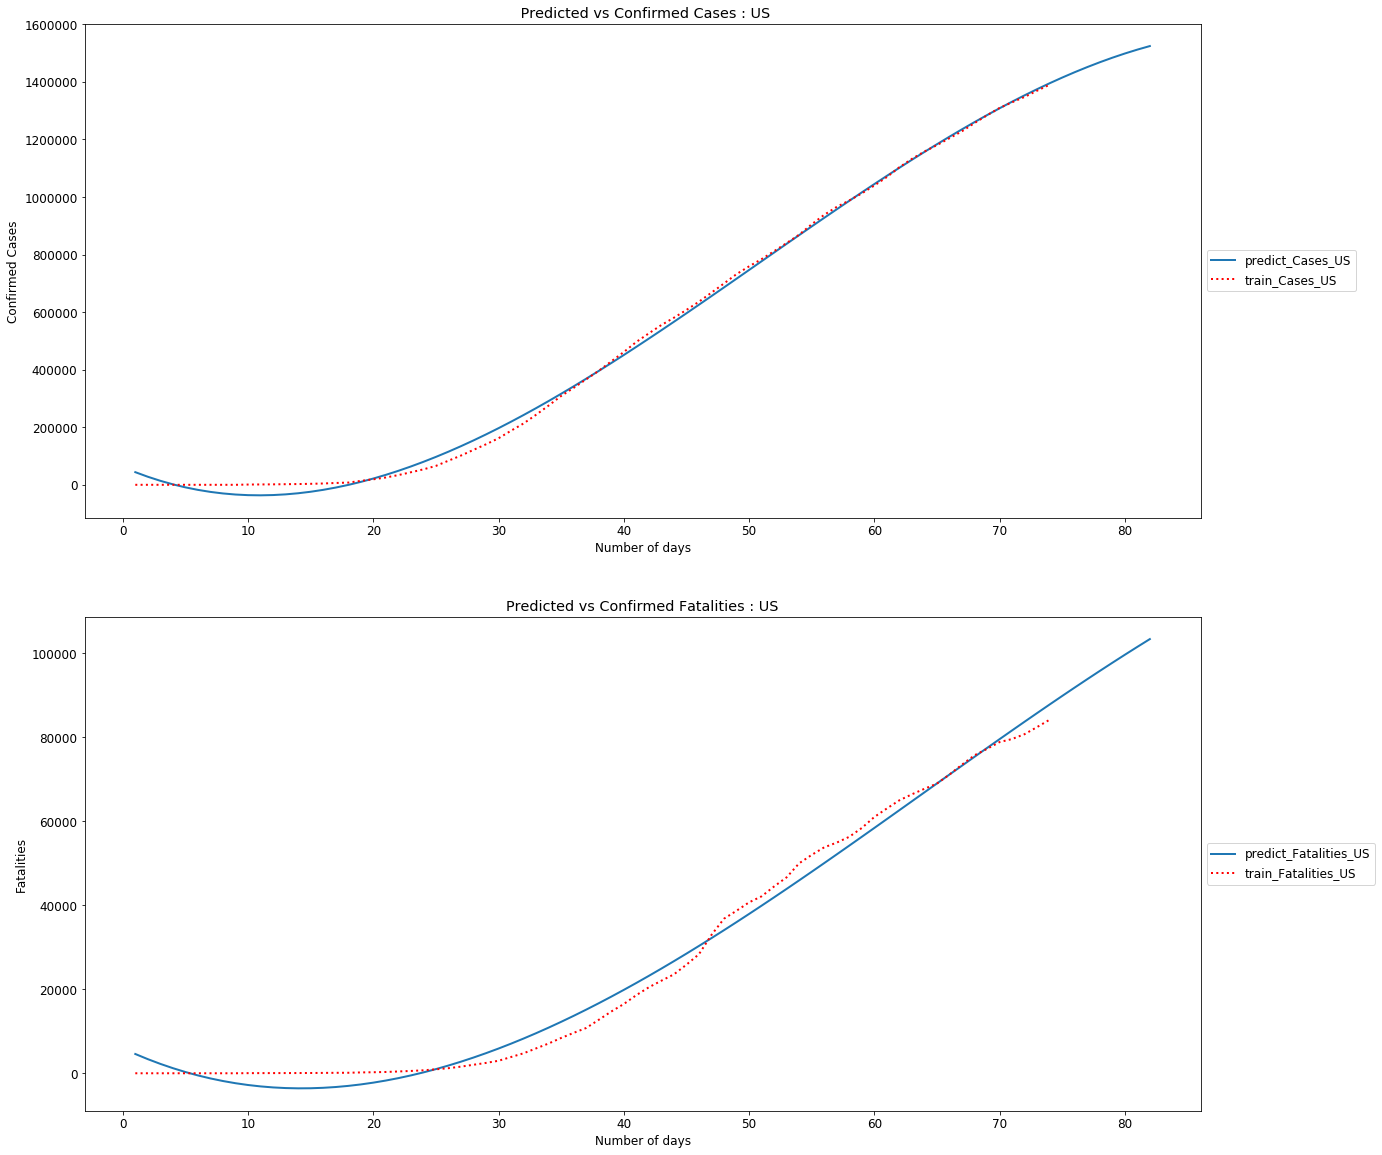

In [291]:
    countries_pred = 'US'

# Take the 1st day as 2020-02-23
    df = df_train1.loc[df_train1.Date >= '2020-03-01']
    n_days_europe = df.Date.nunique()
    print(n_days_europe)
#for i in range(1, len(countries_pred)): 
    df_country_train = df_train1[df_train1['Country_Region']==countries_pred ]
    #df_country_test = df_test1[df_test1['Country_Region']==countries_pred]  
    df_country_train = df_country_train.reset_index()[df_country_train.reset_index().Date >= '2020-03-01']
   # df_country_train
    x_train = np.arange(1, n_days_europe+1).reshape((-1,1))
    x_test  = (np.arange(1,n_test_days+1+overlap_days)).reshape((-1,1)) 
    # ****************** Fatalities ****************************
    y_train_f = df_country_train['Fatalities']
    model_f = make_pipeline(PolynomialFeatures(degree=3), Ridge(fit_intercept=False)) 
    model_f = model_f.fit(x_train, y_train_f)
    y_predict_f = model_f.predict(x_test) 

# ******************* Cases ******************************
    y_train_c = df_country_train['ConfirmedCases'] 
    model_c = make_pipeline(PolynomialFeatures(degree=3), Ridge(fit_intercept=False)) 
    model_c = model_c.fit(x_train, y_train_c)
    y_predict_c = model_c.predict(x_test)

# ***************** Figure **************************
    plt.rcParams.update({'font.size': 12})
    fig,(ax0,ax1) = plt.subplots(2,1,figsize=(20, 20))


    
    ax0.plot(x_test, y_predict_c,linewidth=2, label='predict_Cases_'+countries_pred)
    ax0.plot(x_train, y_train_c, linewidth=2, color='r', linestyle='dotted', label='train_Cases_'+countries_pred)
    ax0.set_title( " Predicted vs Confirmed Cases : " +countries_pred)
    ax0.set_xlabel("Number of days")
    ax0.set_ylabel("Confirmed Cases")
    ax0.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    
    ax1.plot(x_test, y_predict_f,linewidth=2, label='predict_Fatalities_'+countries_pred)
    ax1.plot(x_train, y_train_f, linewidth=2, color='r', linestyle='dotted', label='train_Fatalities_'+countries_pred)
    ax1.set_title("Predicted vs Confirmed Fatalities : " + countries_pred)
    ax1.set_xlabel("Number of days")
    ax1.set_ylabel("Fatalities")
    ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    


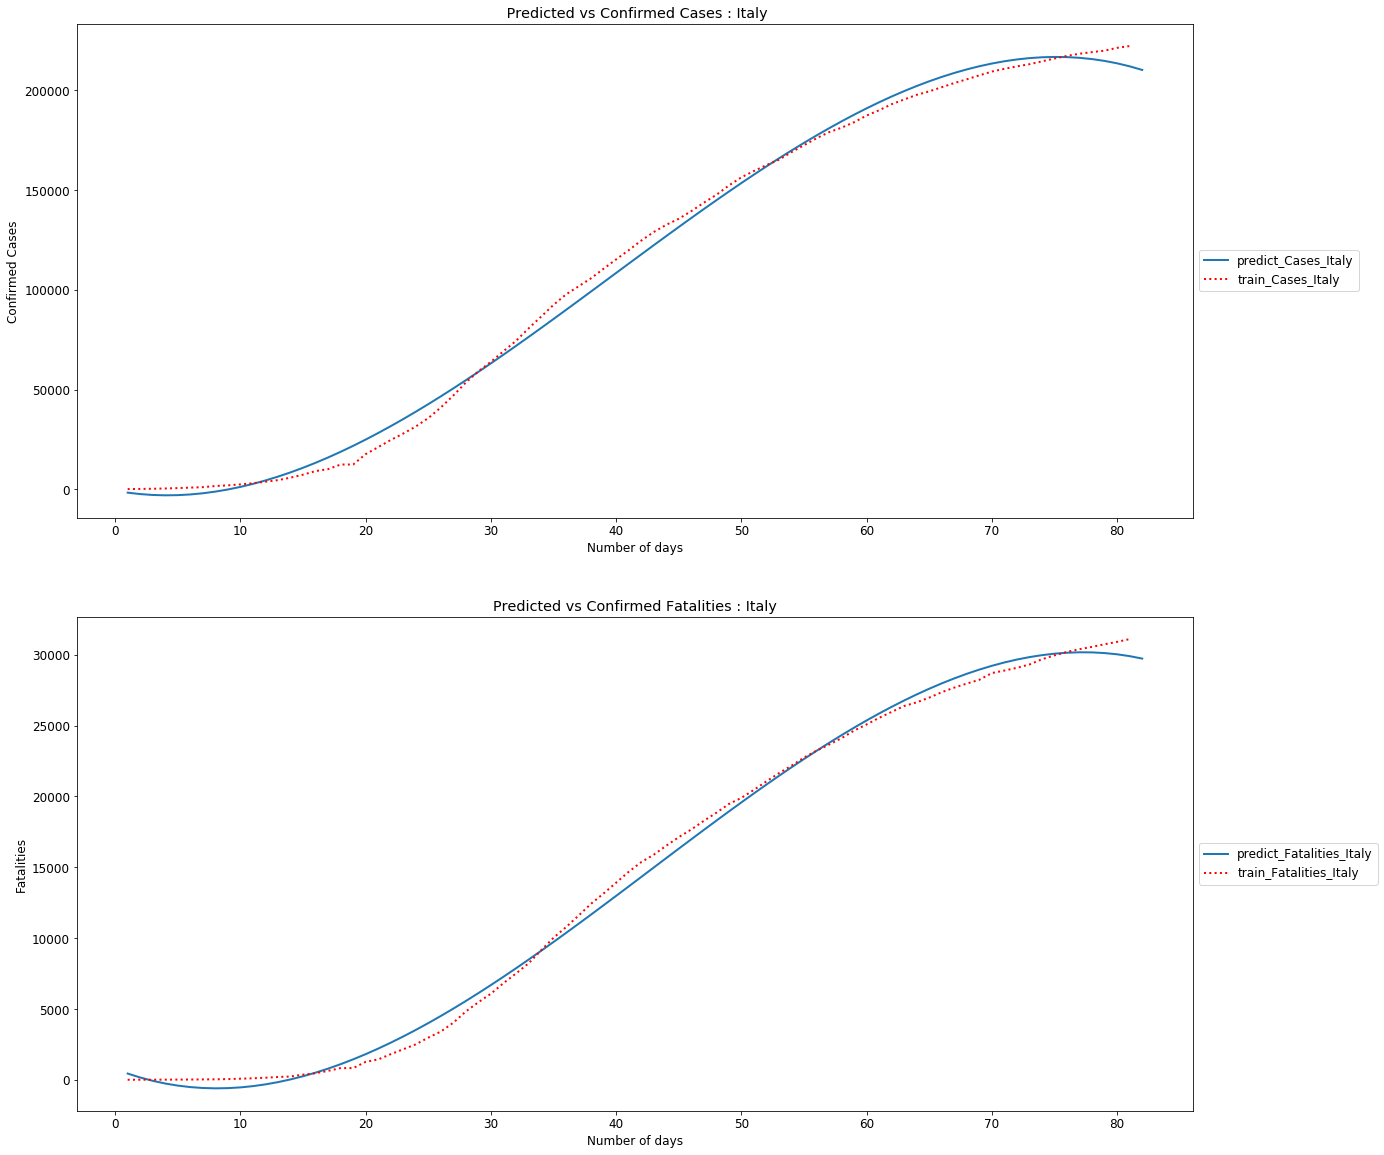

In [292]:
    countries_pred = 'Italy'

# Take the 1st day as 2020-02-23
    df = df_train1.loc[df_train1.Date >= '2020-02-23']
    n_days_europe = df.Date.nunique()

#for i in range(1, len(countries_pred)): 
    df_country_train = df_train1[df_train1['Country_Region']==countries_pred ]
    df_country_test = df_test[df_test['Country_Region']==countries_pred]  
    df_country_train = df_country_train.reset_index()[df_country_train.reset_index().Date > '2020-02-22']
    
    x_train = np.arange(1, n_days_europe+1).reshape((-1,1))
    x_test  = (np.arange(1,n_test_days+1+overlap_days)).reshape((-1,1)) 

# ****************** Fatalities ****************************
    y_train_f = df_country_train['Fatalities']
    model_f = make_pipeline(PolynomialFeatures(degree=3), Ridge(fit_intercept=False)) 
    model_f = model_f.fit(x_train, y_train_f)
    y_predict_f = model_f.predict(x_test) 

# ******************* Cases ******************************
    y_train_c = df_country_train['ConfirmedCases'] 
    model_c = make_pipeline(PolynomialFeatures(degree=3), Ridge(fit_intercept=False)) 
    model_c = model_c.fit(x_train, y_train_c)
    y_predict_c = model_c.predict(x_test)

# ***************** Figure **************************
    plt.rcParams.update({'font.size': 12})
    fig,(ax0,ax1) = plt.subplots(2,1,figsize=(20, 20))


    
    ax0.plot(x_test, y_predict_c,linewidth=2, label='predict_Cases_'+countries_pred)
    ax0.plot(x_train, y_train_c, linewidth=2, color='r', linestyle='dotted', label='train_Cases_'+countries_pred)
    ax0.set_title( " Predicted vs Confirmed Cases : " +countries_pred)
    ax0.set_xlabel("Number of days")
    ax0.set_ylabel("Confirmed Cases")
    ax0.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    
    ax1.plot(x_test, y_predict_f,linewidth=2, label='predict_Fatalities_'+countries_pred)
    ax1.plot(x_train, y_train_f, linewidth=2, color='r', linestyle='dotted', label='train_Fatalities_'+countries_pred)
    ax1.set_title("Predicted vs Confirmed Fatalities : " + countries_pred)
    ax1.set_xlabel("Number of days")
    ax1.set_ylabel("Fatalities")
    ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


82


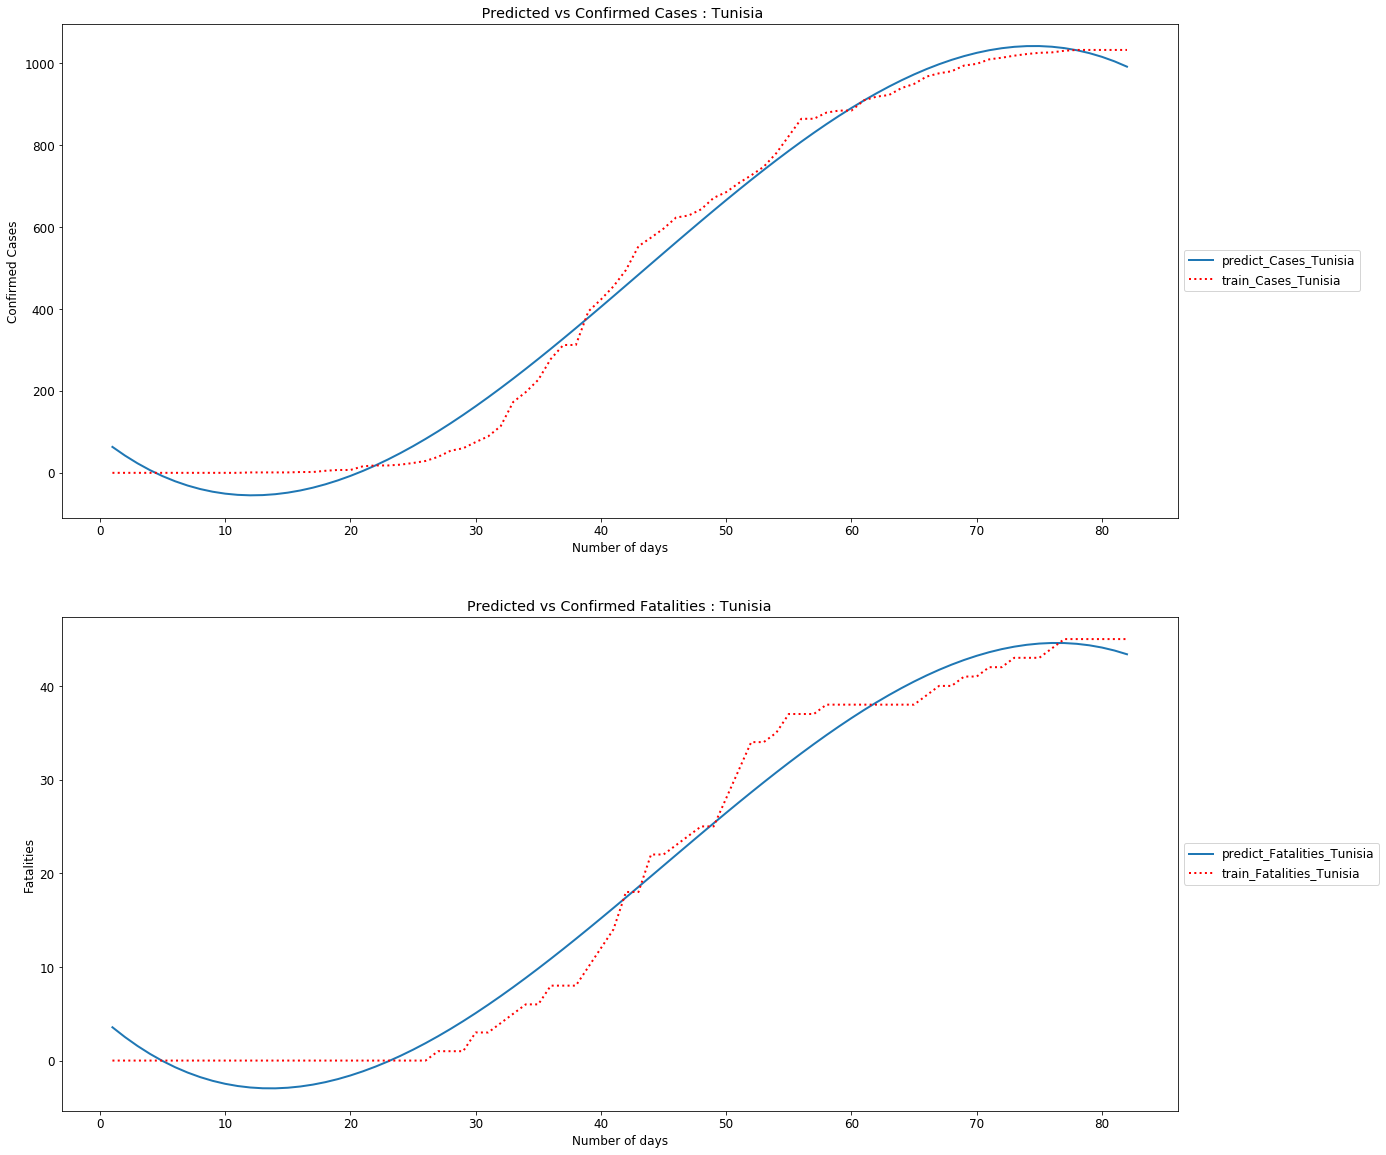

In [293]:
    countries_pred = 'Tunisia'

# Take the 1st day as 2020-02-23
    df = df_train1.loc[df_train1.Date >= '2020-02-22']
    n_days_europe = df.Date.nunique()
    print(n_days_europe)
#for i in range(1, len(countries_pred)): 
    df_country_train = df_train1[df_train1['Country_Region']==countries_pred ]
    df_country_test = df_test[df_test['Country_Region']==countries_pred]  
    df_country_train = df_country_train.reset_index()[df_country_train.reset_index().Date >= '2020-02-22']
    
    x_train = np.arange(1, n_days_europe+1).reshape((-1,1))
    x_test  = (np.arange(1,n_test_days+1+overlap_days)).reshape((-1,1)) 

# ****************** Fatalities ****************************
    y_train_f = df_country_train['Fatalities']
    model_f = make_pipeline(PolynomialFeatures(degree=3), Ridge(fit_intercept=False)) 
    model_f = model_f.fit(x_train, y_train_f)
    y_predict_f = model_f.predict(x_test) 

# ******************* Cases ******************************
    y_train_c = df_country_train['ConfirmedCases'] 
    model_c = make_pipeline(PolynomialFeatures(degree=3), Ridge(fit_intercept=False)) 
    model_c = model_c.fit(x_train, y_train_c)
    y_predict_c = model_c.predict(x_test)

# ***************** Figure **************************
    plt.rcParams.update({'font.size': 12})
    fig,(ax0,ax1) = plt.subplots(2,1,figsize=(20, 20))


    
    ax0.plot(x_test, y_predict_c,linewidth=2, label='predict_Cases_'+countries_pred)
    ax0.plot(x_train, y_train_c, linewidth=2, color='r', linestyle='dotted', label='train_Cases_'+countries_pred)
    ax0.set_title( " Predicted vs Confirmed Cases : " +countries_pred)
    ax0.set_xlabel("Number of days")
    ax0.set_ylabel("Confirmed Cases")
    ax0.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    
    ax1.plot(x_test, y_predict_f,linewidth=2, label='predict_Fatalities_'+countries_pred)
    ax1.plot(x_train, y_train_f, linewidth=2, color='r', linestyle='dotted', label='train_Fatalities_'+countries_pred)
    ax1.set_title("Predicted vs Confirmed Fatalities : " + countries_pred)
    ax1.set_xlabel("Number of days")
    ax1.set_ylabel("Fatalities")
    ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


#### Apply other models
#### Ridge

In [294]:
X_trainR,X_testR,y_trainR,y_testR = train_test_split(df_train_final_ConCases,y_conf,test_size=0.2,random_state=42)

In [295]:
ridge = Ridge(10)
ridge.fit(X_trainR,y_trainR)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [296]:
y_predR = ridge.predict(X_testR)

In [297]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(Ridge(), {'alpha': [0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.8,20]}, cv=2, return_train_score=False)
clf.fit(X_trainR, y_trainR)
clf.cv_results_
clf.best_score_

0.052207604936034435

In [298]:
ridge.score(X_testR,y_testR)


0.05429914132069103

In [299]:
from sklearn.metrics import mean_squared_error
r=np.sqrt(mean_squared_error(y_testR,y_predR))
r

18677.260609990837

In [300]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_testR,y_predR)
print('MAE: %f' % mae)

MAE: 5818.829776


In [301]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_testR,y_predR)
print('MSE: %f' % mse)

MSE: 348840063.893515


In [302]:
from math import sqrt
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 18677.260610


In [303]:
from sklearn.metrics import r2_score
R2=r2_score(y_testR,y_predR)
print('R2: %f' % R2)

R2: 0.054299


### We can conclude that linear model with regularization such as ridge doesn't present good performance with R^2=0.054 and RMSE=18677.26

# ----------------------------------------------------------------------------------------------------

### CART

In [304]:
from sklearn.model_selection import train_test_split
X_trainC,X_testC,y_trainC,y_testC = train_test_split(df_train_final_ConCases,y_conf,test_size=0.2,random_state=42)

In [305]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
clf1 = RandomizedSearchCV(DecisionTreeRegressor(), {'max_leaf_nodes':[200,500,1000,2000,2200],
                                              "criterion": ["mse", "mae"],
                                              "min_samples_split": [10, 20, 40],
                                              "max_depth": [2, 6, 8],
                                              "min_samples_leaf": [20, 40, 100],
                                              "max_leaf_nodes": [5, 20, 100],
                                             }, cv=5, return_train_score=False)
clf1.fit(X_trainC, y_trainC)
print(clf1.best_score_)


0.38999094420066244


In [306]:
cart = DecisionTreeRegressor(max_leaf_nodes = 60)
cart.fit(X_trainC,y_trainC)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=60,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [307]:
y_predC = cart.predict(X_testC)

In [308]:
cart.score(X_testC,y_testC)


0.8618021272303129

In [309]:
from sklearn.metrics import mean_squared_error
r=np.sqrt(mean_squared_error(y_testC,y_predC))
r

7139.815117885752

In [310]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_testC,y_predC)
print('MAE: %f' % mae)

MAE: 2188.061360


In [311]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_testC,y_predC)
print('MSE: %f' % mse)

MSE: 50976959.917590


In [312]:
from math import sqrt
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 7139.815118


In [313]:
from sklearn.metrics import r2_score
R2=r2_score(y_testC,y_predC)
print('R2: %f' % R2)

R2: 0.861802


In [314]:
dfpred_fatC = pd.DataFrame(data=y_predC, columns=[ "pred"] , index=y_testC.index )
dfpred_fat1C=pd.concat([dfpred_fatC,y_testC],axis=1)
dfpred_fat1C.sample(30)

,pred,ConfirmedCases
20001,413.823096,0
21916,2951.726829,3112
24313,413.823096,0
17969,413.823096,0
15080,413.823096,0
5018,413.823096,0
19961,1435.538210,14
15959,413.823096,0
13063,3822.073964,106
13868,3822.073964,32


In [315]:
df_train_final_ConCases

,Country_Region,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,2,1,1,22,22,4
1,0,3,1,1,23,23,4
2,0,4,1,1,24,24,4
3,0,5,1,1,25,25,4
4,0,6,1,1,26,26,4
...,...,...,...,...,...,...,...
35364,312,5,2,5,130,9,19
35365,312,6,2,5,131,10,19
35366,312,0,2,5,132,11,20
35367,312,1,2,5,133,12,20


In [316]:
X_traina,X_testa,y_traina,y_testa = train_test_split(df_train_final_ConCases,y_conf,test_size=0.2,random_state=42)
regr = AdaBoostRegressor( n_estimators=500,learning_rate=0.000000005,random_state=0)
regr

AdaBoostRegressor(base_estimator=None, learning_rate=5e-09, loss='linear',
                  n_estimators=500, random_state=0)

In [317]:
regr.fit(X_traina, y_traina)
regr.score(X_traina,y_traina)

0.1799769246599261

In [318]:
pred_conf_ada = regr.predict(X_testa)
predictions_ada = [round(value) for value in pred_conf_ada]
dfpredada = pd.DataFrame(data=predictions_ada, columns=[ "pred"] , index=y_test.index )
dfpredada=pd.concat([dfpredada,y_test],axis=1)
dfpredada.sample(30)

,pred,ConfirmedCases
33059,1374.0,145
8147,211.0,23
27954,211.0,0
6742,1712.0,1532
14426,4968.0,103374
19922,211.0,0
23102,214.0,28
7277,221.0,481
7478,221.0,49
23217,218.0,1


In [319]:
param_dist = {
 'n_estimators': [200,400,600,800,1000,1200],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
clf1 = RandomizedSearchCV(AdaBoostRegressor(),param_dist, cv=5, return_train_score=False)
clf1.fit(X_traina, y_traina)
print(clf1.best_score_)

0.015214646251037833


In [320]:
print(clf1.best_score_)

0.015214646251037833


In [321]:
pred_conf_ada = regr.predict(X_testa)
predictions_ada = [round(value) for value in pred_conf_ada]
#pred_conf_ada
#predictions_ada 

In [322]:
regr.score(X_traina,y_traina)

0.1799769246599261

In [323]:
regr.score(X_testa,y_testa)

0.1474428252239427

In [324]:
dfpredada = pd.DataFrame(data=predictions_ada, columns=[ "pred"] , index=y_test.index )
dfpredada=pd.concat([dfpredada,y_test],axis=1)
dfpredada.sample(30)

,pred,ConfirmedCases
21075,272.0,2460
28719,211.0,0
32592,213.0,0
4877,221.0,0
32333,211.0,0
6373,221.0,576
26599,211.0,1
27438,15310.0,11278
27465,211.0,0
11550,211.0,0


### Other method DataClean 

In [325]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_train['Country_Region'] = df_train['Country_Region'].astype(str)
df_test['Country_Region'] = df_test['Country_Region'].astype(str)

In [326]:
df_train.loc[:, 'Date_'] = df_train.Date.dt.strftime("%m%d")
df_train["Date_"]  = df_train["Date_"].astype(int)

df_test.loc[:, 'Date_'] = df_test.Date.dt.strftime("%m%d")
df_test["Date_"]  = df_test["Date_"].astype(int)

In [327]:
df_train['Date_']

0        122
1        123
2        124
3        125
4        126
        ... 
35364    509
35365    510
35366    511
35367    512
35368    513
Name: Date_, Length: 35369, dtype: int32

In [328]:
df_finaldate= pd.DataFrame(df_train_final_ConCases['Country_Region'] , columns=['Country_Region'] , index=df_train_final_ConCases.index)
df_finaldate  =pd.concat([df_finaldate , df_train['Date_']] ,axis=1)

In [329]:
df_finaldate

,Country_Region,Date_
0,0,122
1,0,123
2,0,124
3,0,125
4,0,126
...,...,...
35364,312,509
35365,312,510
35366,312,511
35367,312,512


#### SVM

In [330]:
from sklearn.model_selection import train_test_split
X_trainS,X_testS,y_trainS,y_testS = train_test_split(df_finaldate,y_conf,test_size=0.2,random_state=42)

In [331]:
regressor = SVR(kernel='rbf')
regressor.fit(X_trainS,y_trainS)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [332]:
y_predS = regressor.predict(X_testS)

In [333]:
regressor.score(X_trainS,y_trainS)


-0.02625796908414646

In [334]:
regressor.score(X_testS,y_testS)


-0.02748785007944354

In [335]:
from sklearn.metrics import mean_squared_error
r=np.sqrt(mean_squared_error(y_testS,y_predS))
r

19468.147793175136

In [336]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_testS,y_predS)
print('MAE: %f' % mae)

MAE: 3636.638919


In [337]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_testS,y_predS)
print('MSE: %f' % mse)

MSE: 379008778.496910


In [338]:
from math import sqrt
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 19468.147793


In [339]:
from sklearn.metrics import r2_score
R2=r2_score(y_testS,y_predS)
print('R2: %f' % R2)

R2: -0.027488


# -------------------------------------------------------------------------------------------------------------

# ---------------------- ----------- ----------- Forcast using Time Series ----------- ----------- ----------------------

# -------------------------------------------------------------------------------------------------------------

### Import necessary packages

In [143]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [148]:
#Import train & test data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [149]:
train.sample(3)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
28551,28804,Indiana,US,2020-04-06,4956.0,143.0
19127,19297,NaN,Mali,2020-02-21,0.0,0.0
11283,11383,NaN,Diamond Princess,2020-04-27,712.0,13.0


In [150]:
test.sample(3)

,ForecastId,Province_State,Country_Region,Date
12041,12042,South Dakota,US,2020-04-03
6249,6250,NaN,Israel,2020-04-16
6205,6206,NaN,Ireland,2020-04-15


In [151]:
# Group the data by date and country region
df=train.groupby(['Date','Country_Region']).agg('sum').reset_index()
df.tail(5)

,Date,Country_Region,Id,ConfirmedCases,Fatalities
20787,2020-05-13,Vietnam,35225,288.0,0.0
20788,2020-05-13,West Bank and Gaza,35339,375.0,2.0
20789,2020-05-13,Western Sahara,35453,6.0,0.0
20790,2020-05-13,Zambia,35567,446.0,7.0
20791,2020-05-13,Zimbabwe,35681,37.0,4.0


In [152]:
#convert date feature into datetime
test['Date'] = pd.to_datetime(test['Date'])
train['Date'] = pd.to_datetime(train['Date'])

In [154]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a dataframe time serie of confirmed cases for a specific country  plotting the rolled mean and standard 
def roll(country,case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())

# Function for plotting the rolled mean and standard deviation of the confirmed cases for a designated country
def rollPlot(country, case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

In [155]:
#Function for making a dataframe time serie of fatalities for a specific country
def roll2(country,case='Fatalities'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Fatalities']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())

In [156]:
#Function to check if the dataframe is stationary or not using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)
    return(test[1])


In [157]:
# Function to visualize the corrolation
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    

In [158]:
#set the dataframe index to date
train = train.set_index(['Date'])
test = test.set_index(['Date'])

In [159]:
# Function to calculate Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

In [160]:
#Function to split time series into train and test
def split(ts):
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)

In [164]:
#prepare the ARIMA parametrs with d=0
list1=[]
for i in range (0,6):
    for j in range(0,6):
        k=(i,0,j)
        list1.append(k)
pdq=list1

In [165]:
#Arima modeling for confirmed cases time series
def arima(ts,test,tsc):
    list1=[]
    kk=stationarity(tsc)
    if kk<0.05:
        for i in range (0,4):
            for j in range(0,4):
                k=(i,0,j)
                list1.append(k)
        pdq=list1
    else :
        p=d=q=range(0,6)
        a=99999
        pdq=list(itertools.product(p,d,q))
   # print(pdq)
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()
            param=var
            if (result.aic<=a) :
                a=result.aic
                param=var
           # else :
               # param=(2,0,2)
        except:
            continue  
  #  param=(2,0,2)
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts)*0.7), end=int(len(ts) * 1.6))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)

## US Case
### Confirmed Cases

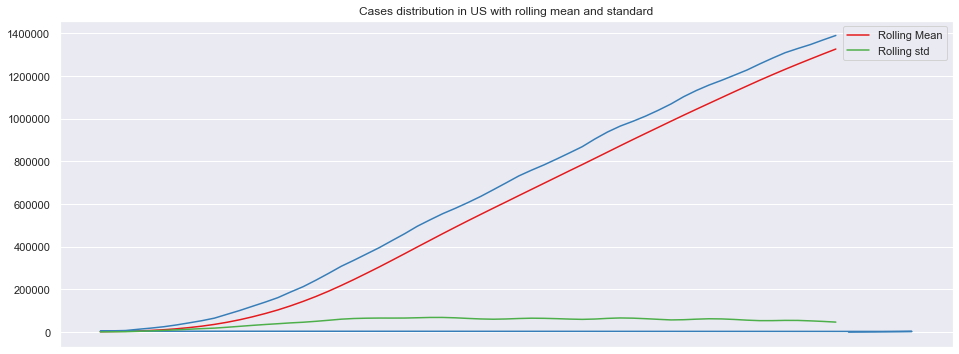

In [168]:
tsC_us=roll('US')
rollPlot('US')

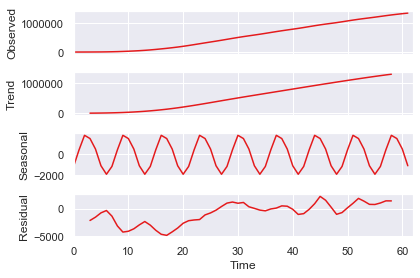

In [169]:
#Decompose the time series into trend,seasonal and residual 
fig=sm.tsa.seasonal_decompose(tsC_us.values,freq=7).plot()

In [170]:
tsC_us=tsC_us['ConfirmedCases']
stationarity(tsC_us)

Results of Dickey-Fuller Test:
Test Statistic                 -1.156983
p-value                         0.691822
#Lags Used                      9.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


0.6918216188056945

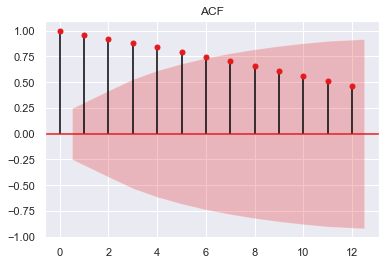

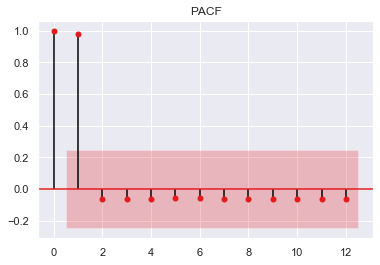

In [171]:
corr(tsC_us)

Results of Dickey-Fuller Test:
Test Statistic                 -1.156983
p-value                         0.691822
#Lags Used                      9.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:      D2.ConfirmedCases   No. Observations:                   50
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -398.681
Method:                       css-mle   S.D. of innovations            674.248
Date:                Mon, 18 May 2020   AIC                            811.361
Time:                        16:04:24   BIC                            824.745
Sample:                    03-15-2020   HQIC                           816.458
                         - 05-03-2020                                         
                              coef 

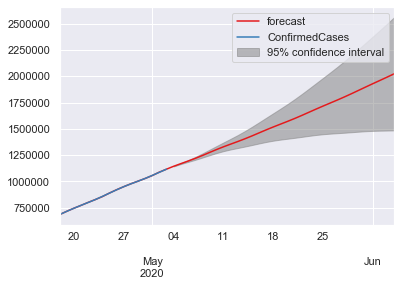

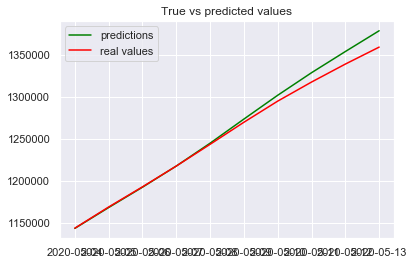

In [172]:
train,test=split(tsC_us)
pred_us=arima(train,test,tsC_us)

### Fatalities 

In [173]:
tsCF_us=roll2('US')
tsCF_us=tsCF_us['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                 -0.850523
p-value                         0.803829
#Lags Used                     10.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D2.Fatalities   No. Observations:                   50
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -320.602
Method:                       css-mle   S.D. of innovations            144.081
Date:                Mon, 18 May 2020   AIC                            657.205
Time:                        16:05:39   BIC                            672.501
Sample:                    03-15-2020   HQIC                           663.030
                         - 05-03-2020                                         
                          coef    s

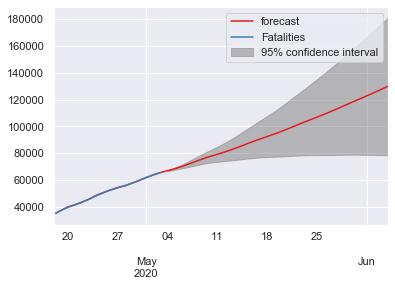

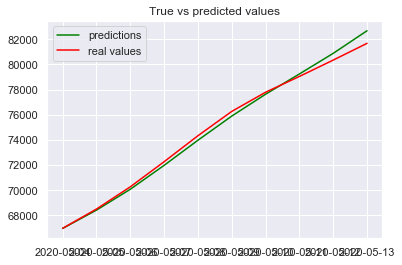

In [174]:
train,test=split(tsCF_us)
pred_us=arima(train,test,tsCF_us)

## China Case

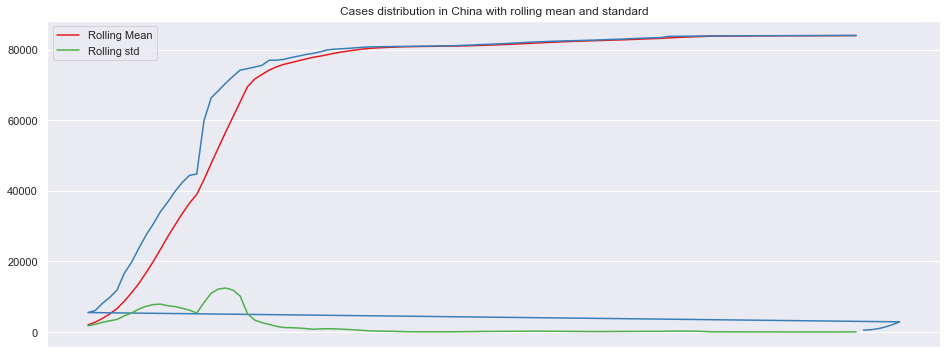

In [175]:
tsC_China=roll('China')
rollPlot('China')

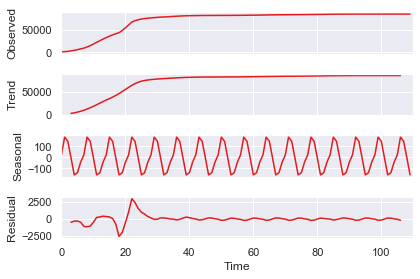

In [176]:
fig=sm.tsa.seasonal_decompose(tsC_China.values,freq=7).plot()

In [177]:
tsC_China=tsC_China['ConfirmedCases'].values
stationarity(tsC_China)

Results of Dickey-Fuller Test:
Test Statistic                 -4.181472
p-value                         0.000708
#Lags Used                     13.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


0.000708132831268855

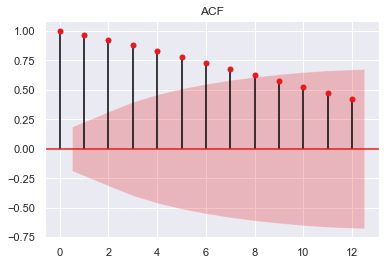

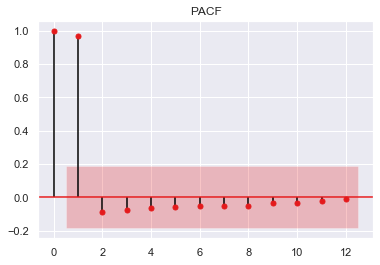

In [50]:
corr(tsC_China)

Results of Dickey-Fuller Test:
Test Statistic                 -4.181472
p-value                         0.000708
#Lags Used                     13.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   93
Model:                     ARMA(3, 2)   Log Likelihood                -716.379
Method:                       css-mle   S.D. of innovations            500.258
Date:                Mon, 18 May 2020   AIC                           1446.758
Time:                        16:07:10   BIC                           1464.486
Sample:                             0   HQIC                          1453.916
                                                                              
                 coef    std err   

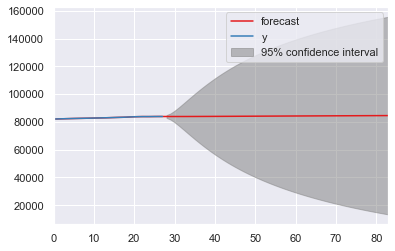

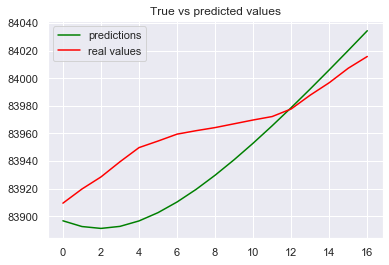

In [178]:
train,test=split(tsC_China)
pred_China=arima(train,test,tsC_China)

### Fatalities 

In [179]:
tsCF_China=roll2('China')
tsCF_China=tsCF_China['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                  -2.218895
p-value                          0.199459
#Lags Used                       9.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D2.Fatalities   No. Observations:                   91
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -465.381
Method:                       css-mle   S.D. of innovations             39.631
Date:                Mon, 18 May 2020   AIC                            948.763
Time:                        16:08:48   BIC                            971.361
Sample:                    01-27-2020   HQIC                           957.880
                         - 04-26-2020                                         
                          co

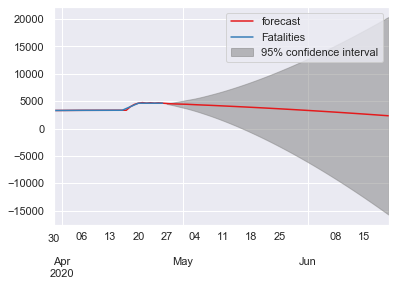

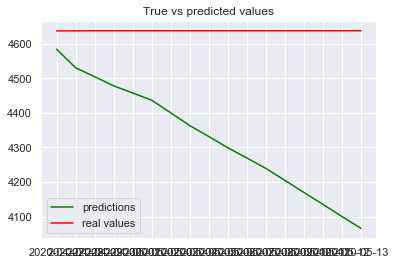

In [180]:
train,test=split(tsCF_China)
predF_Ch=arima(train,test,tsCF_China)

### Italy
### ConfirmedCases

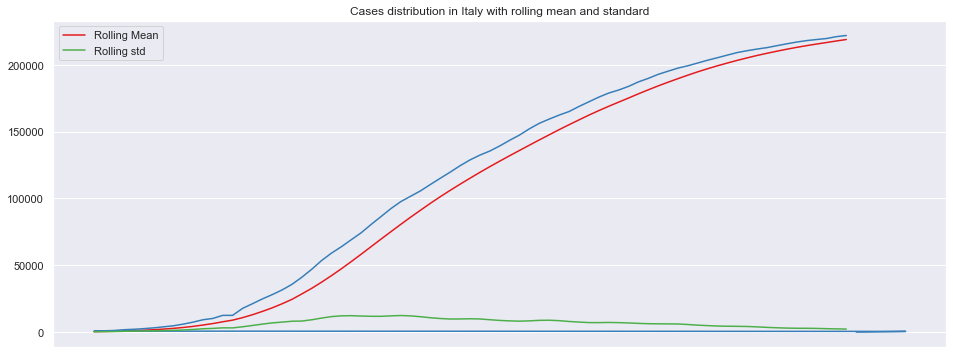

In [185]:
tsC_Italy=roll('Italy')
rollPlot('Italy')

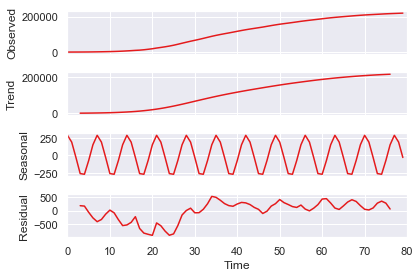

In [186]:
fig=sm.tsa.seasonal_decompose(tsC_Italy.values,freq=7).plot()

In [187]:
tsC_Italy=tsC_Italy['ConfirmedCases'].values
stationarity(tsC_Italy)

Results of Dickey-Fuller Test:
Test Statistic                 -1.492825
p-value                         0.537058
#Lags Used                      8.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


0.5370576320012422

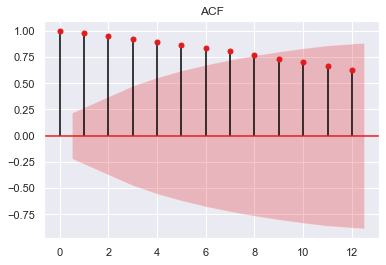

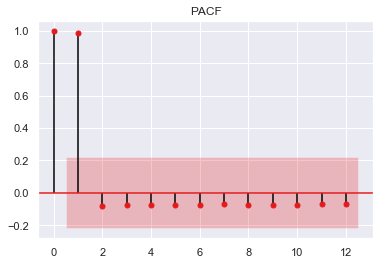

In [188]:
corr(tsC_Italy)

Results of Dickey-Fuller Test:
Test Statistic                 -1.492825
p-value                         0.537058
#Lags Used                      8.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   66
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -440.642
Method:                       css-mle   S.D. of innovations            186.971
Date:                Mon, 18 May 2020   AIC                            899.284
Time:                        16:09:27   BIC                            918.990
Sample:                             2   HQIC                           907.071
                                                                              
                 coef    std err   

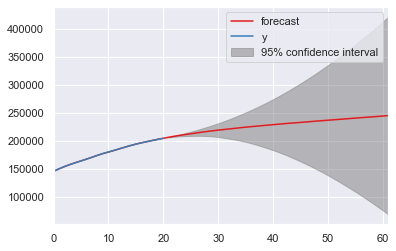

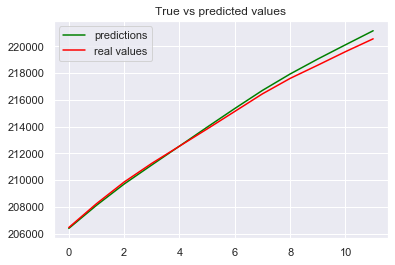

In [189]:
train,test=split(tsC_Italy)
pred_Italy=arima(train,test,tsC_Italy)

### Fatalities

In [190]:
tsCF_Italy=roll2('Italy')
tsCF_Italy=tsCF_Italy['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                 -1.845959
p-value                         0.357895
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D2.Fatalities   No. Observations:                   62
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -292.053
Method:                       css-mle   S.D. of innovations             26.557
Date:                Mon, 18 May 2020   AIC                            600.106
Time:                        16:09:47   BIC                            617.123
Sample:                    03-01-2020   HQIC                           606.787
                         - 05-01-2020                                         
                          coef    s

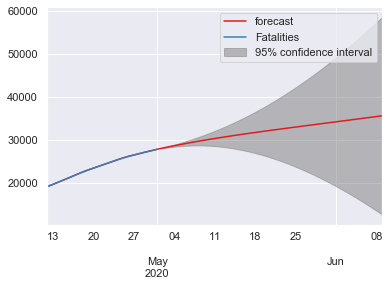

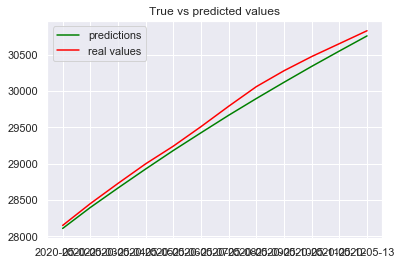

In [191]:
train,test=split(tsCF_Italy)
predF_ita=arima(train,test,tsCF_Italy)

### Spain 
### Confirmed Cases

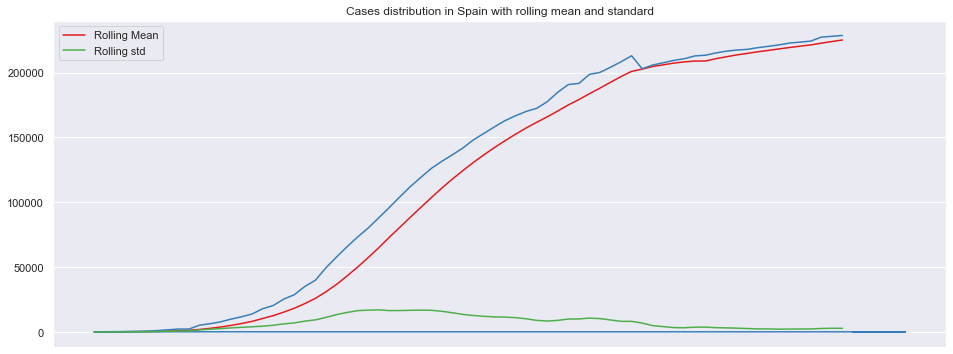

In [193]:
tsC_Spain=roll('Spain')
rollPlot('Spain')

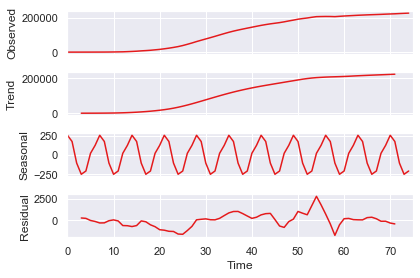

In [194]:
fig=sm.tsa.seasonal_decompose(tsC_Spain.values,freq=7).plot()

In [195]:
tsC_Spain=tsC_Spain['ConfirmedCases'].values
stationarity(tsC_Spain)

Results of Dickey-Fuller Test:
Test Statistic                 -2.062570
p-value                         0.259829
#Lags Used                      9.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


0.2598292152053936

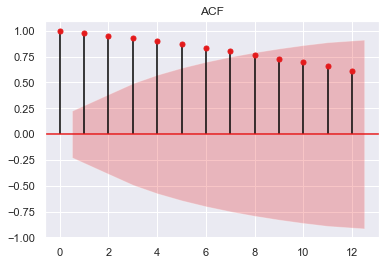

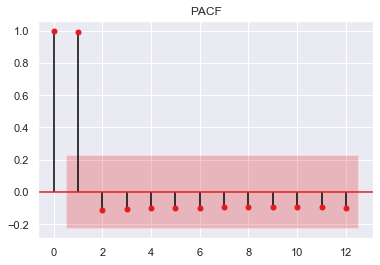

In [196]:
corr(tsC_Spain)

Results of Dickey-Fuller Test:
Test Statistic                 -2.062570
p-value                         0.259829
#Lags Used                      9.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   61
Model:                 ARIMA(5, 2, 3)   Log Likelihood                -474.969
Method:                       css-mle   S.D. of innovations            550.894
Date:                Mon, 18 May 2020   AIC                            969.938
Time:                        16:10:37   BIC                            991.047
Sample:                             2   HQIC                           978.211
                                                                              
                 coef    std err   

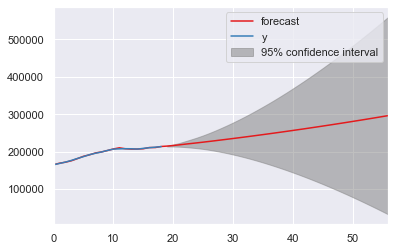

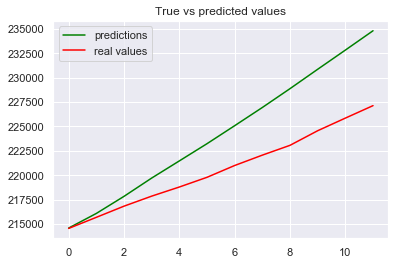

In [197]:
train,test=split(tsC_Spain)
pred_Spain=arima(train,test,tsC_Spain)

### Fatalities

In [198]:
tsCF_Spain=roll2('Spain')
tsCF_Spain=tsCF_Spain['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                 -2.600775
p-value                         0.092837
#Lags Used                      8.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D2.Fatalities   No. Observations:                   53
Model:                 ARIMA(5, 2, 4)   Log Likelihood                -267.246
Method:                       css-mle   S.D. of innovations             35.038
Date:                Mon, 18 May 2020   AIC                            556.492
Time:                        16:10:52   BIC                            578.165
Sample:                    03-12-2020   HQIC                           564.826
                         - 05-03-2020                                         
                          coef    s

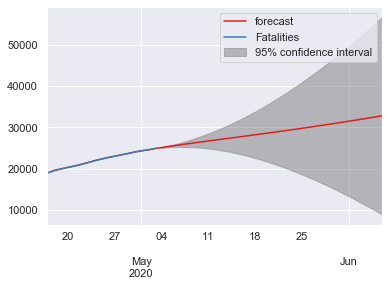

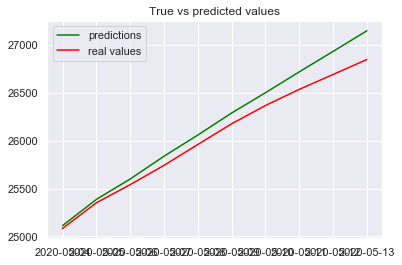

In [199]:
train,test=split(tsCF_Spain)
predF_spa=arima(train,test,tsCF_Spain)

### Germany 

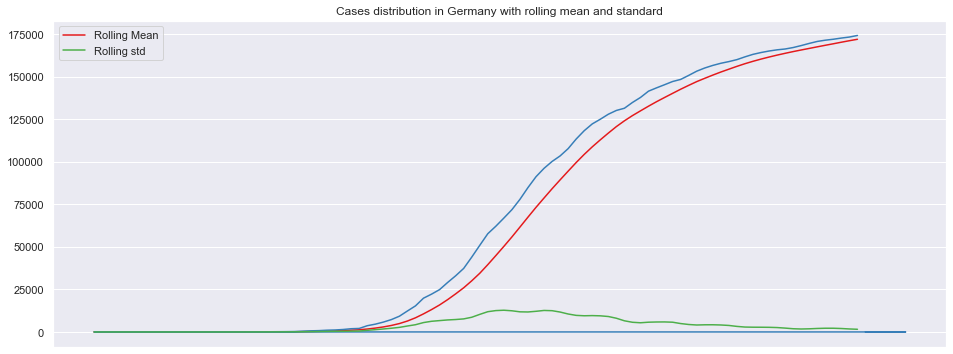

In [200]:
tsC_Germany=roll('Germany')
rollPlot('Germany')

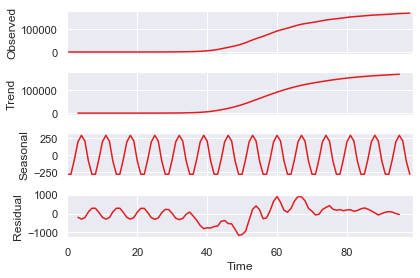

In [201]:
fig=sm.tsa.seasonal_decompose(tsC_Germany.values,freq=7).plot()

In [202]:
tsC_Germany=tsC_Germany['ConfirmedCases'].values
stationarity(tsC_Germany)

Results of Dickey-Fuller Test:
Test Statistic                 -0.284772
p-value                         0.927634
#Lags Used                      9.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


0.9276336144279668

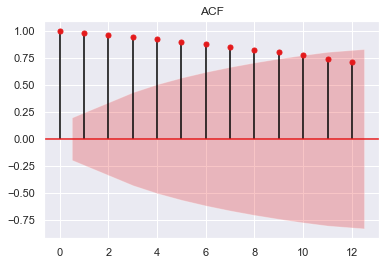

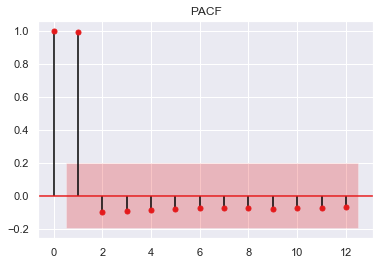

In [203]:
corr(tsC_Germany)

Results of Dickey-Fuller Test:
Test Statistic                 -0.284772
p-value                         0.927634
#Lags Used                      9.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   82
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -535.774
Method:                       css-mle   S.D. of innovations            157.050
Date:                Mon, 18 May 2020   AIC                           1095.548
Time:                        16:11:32   BIC                           1124.429
Sample:                             2   HQIC                          1107.143
                                                                              
                 coef    std err   

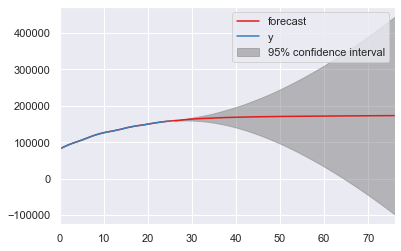

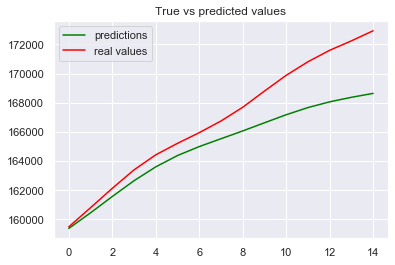

In [204]:
train,test=split(tsC_Germany)
pred_Germany=arima(train,test,tsC_Germany)

### Fatalities 

In [205]:
tsCF_Germany=roll2('Germany')
tsCF_Germany=tsCF_Germany['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                 -3.550841
p-value                         0.006773
#Lags Used                      5.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
                              ARMA Model Results                              
Dep. Variable:             Fatalities   No. Observations:                   48
Model:                     ARMA(1, 0)   Log Likelihood                -316.214
Method:                       css-mle   S.D. of innovations            165.010
Date:                Mon, 18 May 2020   AIC                            638.428
Time:                        16:11:34   BIC                            644.042
Sample:                    03-18-2020   HQIC                           640.550
                         - 05-04-2020                                         
                       coef    std 

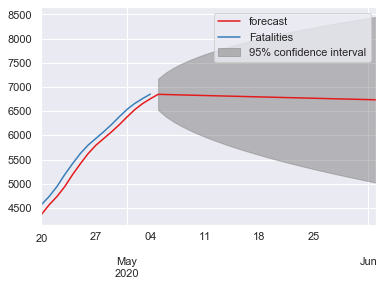

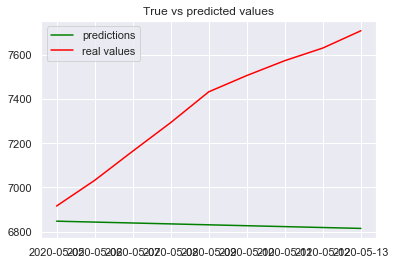

In [206]:
train,test=split(tsCF_Germany)
predF_Ger=arima(train,test,tsCF_Germany)

#  Tunisia 
## Confirmed Cases

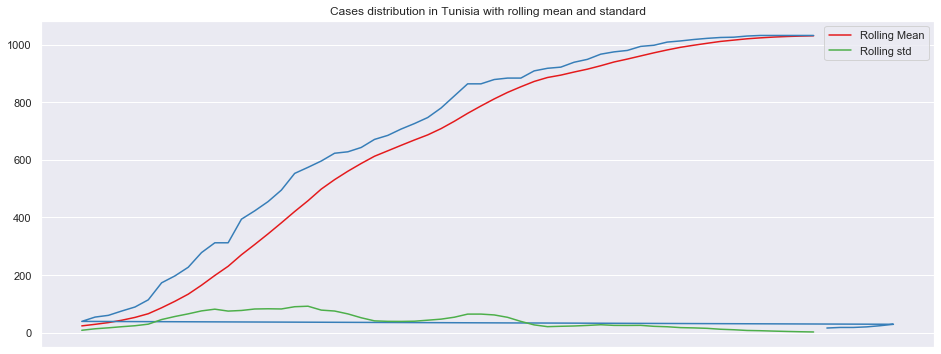

In [207]:
tsC_tn=roll('Tunisia')
rollPlot('Tunisia')

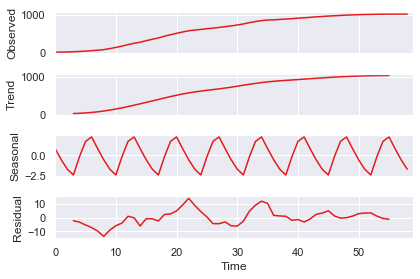

In [208]:
fig=sm.tsa.seasonal_decompose(tsC_tn.values,freq=7).plot()

In [209]:
tsC_tn=tsC_tn['ConfirmedCases']
stationarity(tsC_tn)

Results of Dickey-Fuller Test:
Test Statistic                 -3.702914
p-value                         0.004072
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


0.004072357469189064

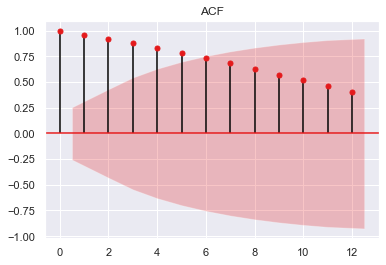

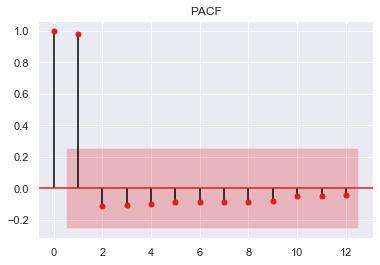

In [210]:
corr(tsC_tn)

Results of Dickey-Fuller Test:
Test Statistic                 -3.702914
p-value                         0.004072
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
                              ARMA Model Results                              
Dep. Variable:         ConfirmedCases   No. Observations:                   50
Model:                     ARMA(3, 1)   Log Likelihood                -158.118
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 18 May 2020   AIC                            328.236
Time:                        16:11:41   BIC                            339.708
Sample:                    03-16-2020   HQIC                           332.604
                         - 05-04-2020                                         
                           coef    

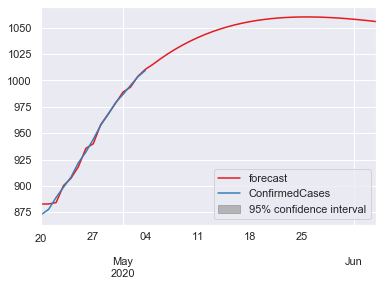

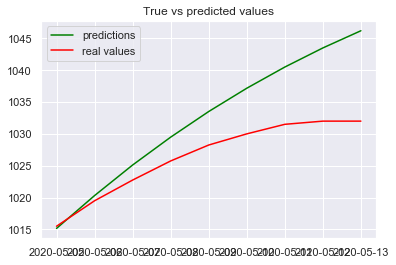

In [211]:
train,test=split(tsC_tn)
pred_tn=arima(train,test,tsC_tn)

Results of Dickey-Fuller Test:
Test Statistic                 -3.702914
p-value                         0.004072
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
                              ARMA Model Results                              
Dep. Variable:         ConfirmedCases   No. Observations:                   50
Model:                     ARMA(3, 1)   Log Likelihood                -158.118
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 18 May 2020   AIC                            328.236
Time:                        16:11:45   BIC                            339.708
Sample:                    03-16-2020   HQIC                           332.604
                         - 05-04-2020                                         
                           coef    

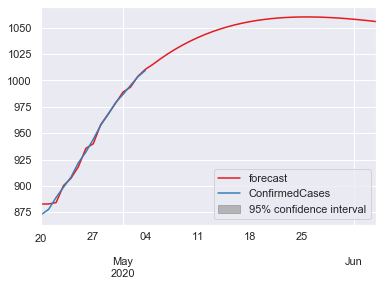

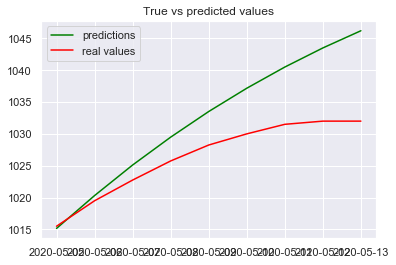

In [212]:
train,test=split(tsC_tn)
pred_tn=arima(train,test,tsC_tn)

### Fatalities 

In [213]:
tsCF_tn=roll2('Tunisia')
tsCF_tn=tsCF_tn['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                 -3.282331
p-value                         0.015687
#Lags Used                      7.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64
                              ARMA Model Results                              
Dep. Variable:             Fatalities   No. Observations:                   34
Model:                     ARMA(3, 1)   Log Likelihood                 -16.202
Method:                       css-mle   S.D. of innovations              0.334
Date:                Mon, 18 May 2020   AIC                             44.403
Time:                        16:11:57   BIC                             53.561
Sample:                    04-03-2020   HQIC                            47.527
                         - 05-06-2020                                         
                       coef    std 

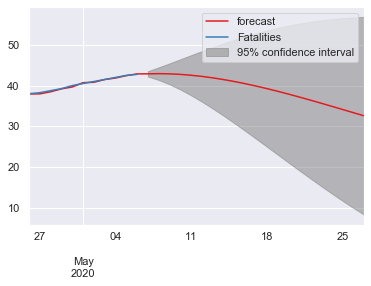

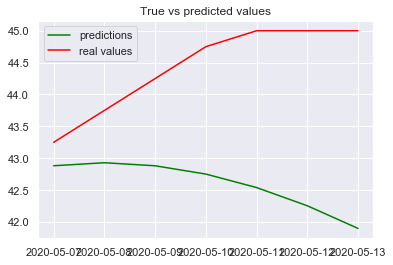

In [214]:
train,test=split(tsCF_tn)
predF_TN=arima(train,test,tsCF_tn)

### Russia 
### Confirmed Cases

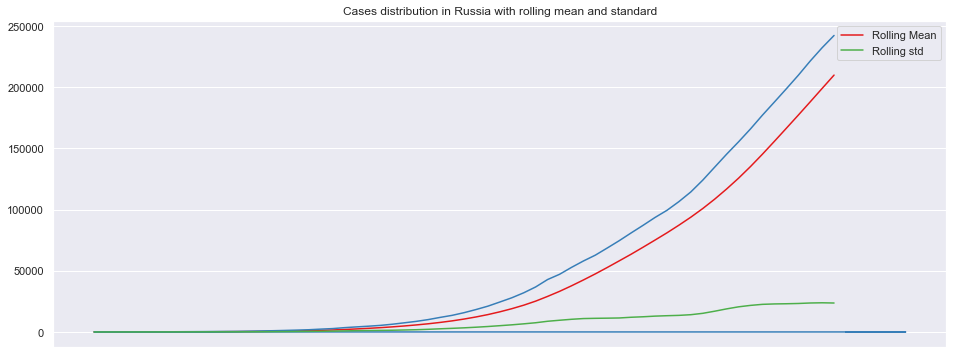

In [215]:
tsC_ru=roll('Russia')
rollPlot('Russia')

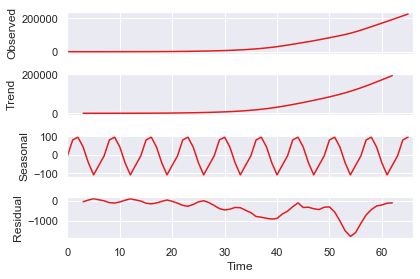

In [216]:
fig=sm.tsa.seasonal_decompose(tsC_ru.values,freq=7).plot()

In [217]:
tsC_ru=tsC_ru['ConfirmedCases'].values
stationarity(tsC_ru)

Results of Dickey-Fuller Test:
Test Statistic                 -2.407478
p-value                         0.139637
#Lags Used                      9.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


0.13963678462824075

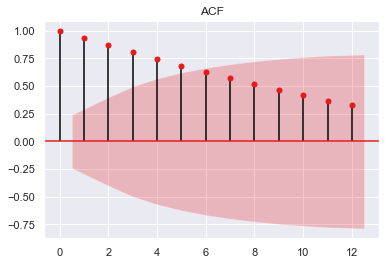

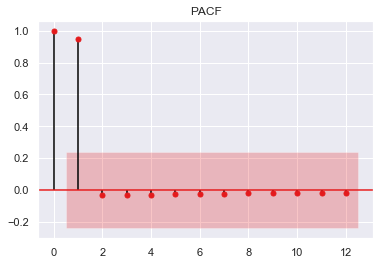

In [218]:
corr(tsC_ru)

Results of Dickey-Fuller Test:
Test Statistic                 -2.407478
p-value                         0.139637
#Lags Used                      9.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   54
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -350.434
Method:                       css-mle   S.D. of innovations            155.647
Date:                Mon, 18 May 2020   AIC                            716.869
Time:                        16:13:56   BIC                            732.781
Sample:                             2   HQIC                           723.006
                                                                              
                 coef    std err   

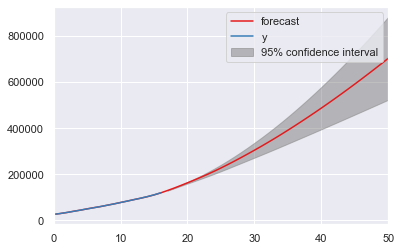

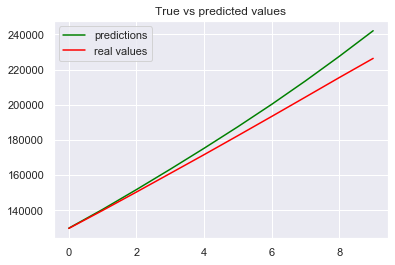

In [219]:
train,test=split(tsC_ru)
pred_ru=arima(train,test,tsC_ru)

### Fatalities

In [220]:
tsCF_ru=roll2('Russia')
tsCF_ru=tsCF_ru['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                 -2.260898
p-value                         0.184889
#Lags Used                      9.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D2.Fatalities   No. Observations:                   32
Model:                 ARIMA(5, 2, 4)   Log Likelihood                 -82.285
Method:                       css-mle   S.D. of innovations              2.718
Date:                Mon, 18 May 2020   AIC                            186.571
Time:                        16:14:21   BIC                            202.694
Sample:                    04-05-2020   HQIC                           191.915
                         - 05-06-2020                                         
                          coef    s

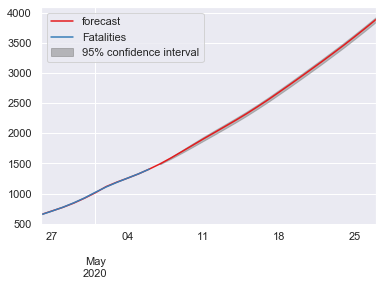

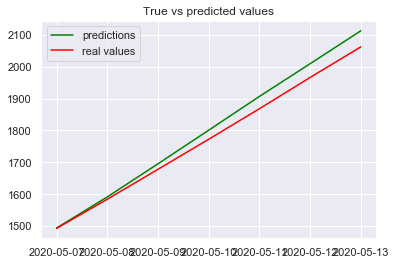

In [221]:
train,test=split(tsCF_ru)
predF_RU=arima(train,test,tsCF_ru)

### Brazil
### Confirmed Cases

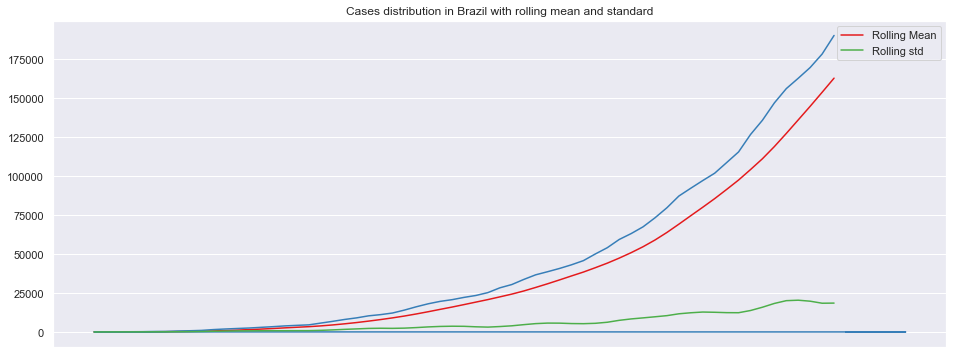

In [222]:
tsC_br=roll('Brazil')
rollPlot('Brazil')

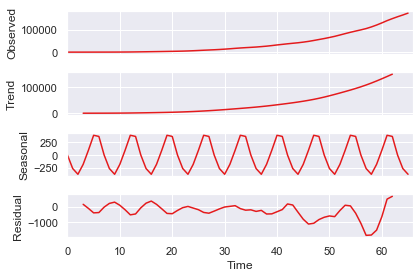

In [223]:
fig=sm.tsa.seasonal_decompose(tsC_br.values,freq=7).plot()

In [224]:
tsC_br=tsC_br['ConfirmedCases']
stationarity(tsC_br)

Results of Dickey-Fuller Test:
Test Statistic                  0.926560
p-value                         0.993427
#Lags Used                      8.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


0.9934273403341054

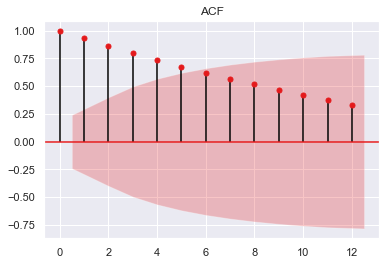

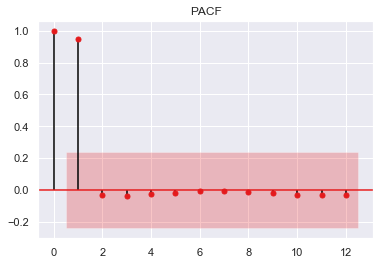

In [225]:
corr(tsC_br)

Results of Dickey-Fuller Test:
Test Statistic                  0.926560
p-value                         0.993427
#Lags Used                      8.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:      D2.ConfirmedCases   No. Observations:                   54
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -352.939
Method:                       css-mle   S.D. of innovations            160.856
Date:                Mon, 18 May 2020   AIC                            721.879
Time:                        16:14:40   BIC                            737.790
Sample:                    03-11-2020   HQIC                           728.015
                         - 05-03-2020                                         
                              coef 

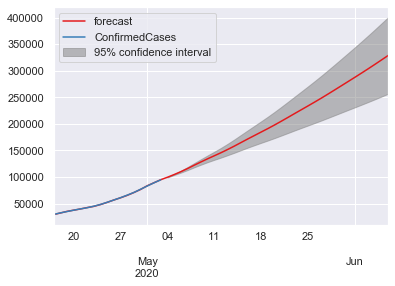

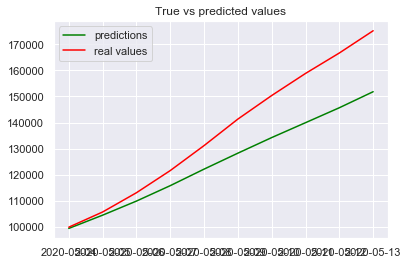

In [226]:
train,test=split(tsC_br)
pred_br=arima(train,test,tsC_br)

### Fatalities 

In [227]:
tsCF_br=roll2('Brazil')
tsCF_br=tsCF_br['Fatalities']

Results of Dickey-Fuller Test:
Test Statistic                  1.946070
p-value                         0.998599
#Lags Used                      6.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:          D2.Fatalities   No. Observations:                   42
Model:                 ARIMA(5, 2, 3)   Log Likelihood                -174.891
Method:                       css-mle   S.D. of innovations             14.519
Date:                Mon, 18 May 2020   AIC                            369.782
Time:                        16:14:55   BIC                            387.159
Sample:                    03-25-2020   HQIC                           376.151
                         - 05-05-2020                                         
                          coef    s

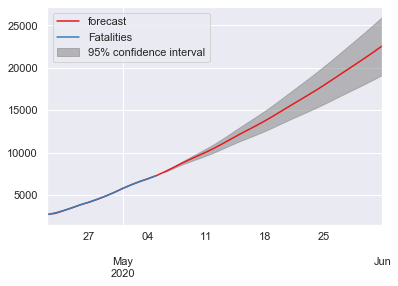

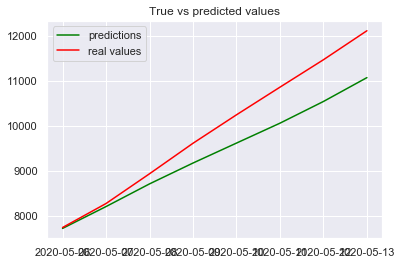

In [228]:
train,test=split(tsCF_br)
predF_br=arima(train,test,tsCF_br)